<a href="https://colab.research.google.com/github/BYU-Handwriting-Lab/GettingStarted/blob/master/notebooks/ARUNetSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ARU-Net Segmentation

This notebook contains code for predicting baselines and seams in historical 
documents. It also contains code for segmenting images based on the seam and
baseline output images.

We follow the approach described in the paper,
[*A Two-Stage Method for Text Line Detection in Historical Documents*](https://arxiv.org/abs/1802.03345), in which they propose an architecture called the
ARU-Net.

The ARU-Net is an extension of the Deep U-Net as recorded in the paper,
[*U-Net: Convolutional Networks for Biomedical Image Segmentation*](https://arxiv.org/abs/1505.04597). The ARU-Net is different from the original U-Net in
the following ways:
* A spatial attention mechanism is added (A for attention)
* Residual blocks replace original convolutional blocks (R for Residual)
* The image is observed at multiple scale spaces

The code currently uses a naive approach to baseline clustering and as a result
is extremely slow. In the future, the second-stage as described in the above
paper should be implemented and updated here.

We extend the approach explained in the paper by training two ARU-Nets. One
for baseline detection and the other for seam detection. Using the output of
these two networks, we can produce line-level segmentations given an input
image.

### Diagrams

Diagrams as given in the paper, [*A Two-Stage Method for Text Line Detection in Historical Documents*](https://arxiv.org/abs/1802.03345).

Diagram of One Residual Block in the RU-Net Architecture

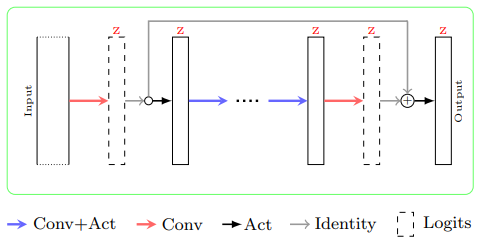

Diagram of the RU-Net Architecture

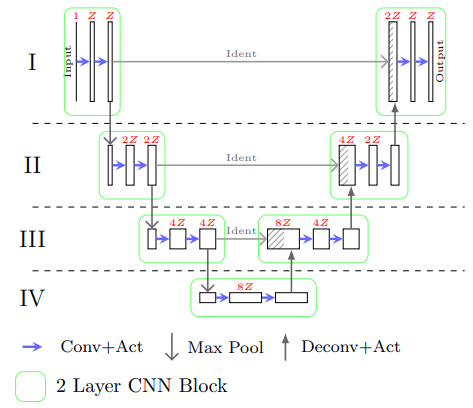

Diagram of the ARU-Net Architecture at three separate scale spaces

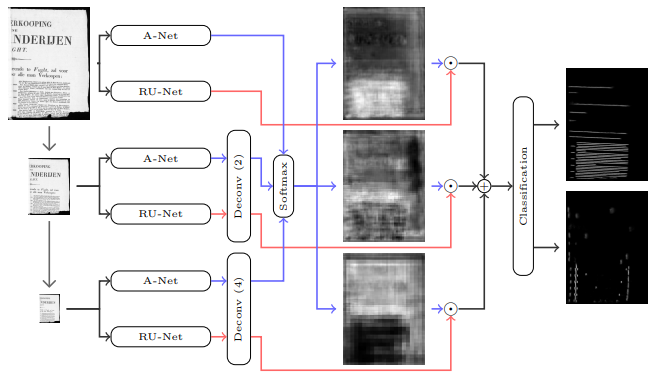

### Imports/Dependencies

Import the dependencies needed to run TensorFlow and to build the ARU-Net.

In [0]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow
import tensorflow as tf
import tensorflow.keras.layers as L
import tensorflow.keras.constraints as C
from tensorflow.keras import Model
from tensorflow.keras import backend as K

# Data Structures
import pandas as pd
import numpy as np
import json
import csv
import html
import numba as nb

# Python
import os
import gc
import string
import re
import time
import io
import sys

# Match
import editdistance as ed

# Image/Plotting
import cv2
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from PIL import Image, ImageDraw
import IPython.display as display
from shapely.geometry import LineString, Point, Polygon, MultiPoint, MultiLineString
from shapely.ops import split
from sklearn.cluster import DBSCAN

# Colab (We can use this if we want to import files from Google Drive)
# from google.colab import drive
# drive.mount('/content/drive')

# Debugging
from tqdm import tqdm
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

Download 10 images from the French Records dataset from Google Drive.

In [0]:
# ID = 10RM658zFHqrGx4ndaDiAwyJM_Qril3TV
# SEAMS ID = 1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv
# FILENAME = baseline_dataset.zip
# !wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=10RM658zFHqrGx4ndaDiAwyJM_Qril3TV' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=10RM658zFHqrGx4ndaDiAwyJM_Qril3TV" -O baseline_dataset.zip && rm -rf /tmp/cookies.txt
!wget -q --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1WBniZc_NS7mIYNxNm3rt7sJC3LaX2Tpv" -O baseline_dataset.zip && rm -rf /tmp/cookies.txt
!unzip -q baseline_dataset.zip
!rm baseline_dataset.zip

Make sure it downloaded successfully

In [4]:
!ls baseline_seams_dataset

baselines  images  seams


### Keras Sequence and TFRecord Dataset Creation

Create the Keras Sequence Class as a place to load images from the dataset.

In [0]:
class BaselineSequence(tf.keras.utils.Sequence):
  def __init__(self, img_path, label_path, desired_size=(768, 1152)):
    self.img_path = img_path
    self.label_path = label_path

    if not os.path.exists(self.img_path) or not os.path.exists(self.label_path):
      raise Exception('Baseline dataset does not exists in', self.img_path)

    self.desired_size = desired_size
    self.imgs = os.listdir(self.img_path)

  def resize(self, img, desired_size):
    img_size = np.array(img).shape

    img_ratio = img_size[0] / img_size[1]
    desired_ratio = desired_size[0] / desired_size[1]

    if img_ratio >= desired_ratio:
      # Solve by height
      new_height = desired_size[0]
      new_width = int(desired_size[0] // img_ratio)
    else:
      new_height = int(desired_size[1] * img_ratio)
      new_width = desired_size[1]
      # Solve by width

    img = np.array(img.resize((new_width, new_height)))

    border_top = desired_size[0] - new_height
    border_right = desired_size[1] - new_width

    img = np.pad(img, [(border_top, 0), (0, border_right)], mode='constant', constant_values=0)

    return img

  def tensor_image(self, path, pil_format):
    img = Image.open(path)
    img = img.convert(pil_format)
    img = self.resize(img, self.desired_size)
    x = tf.constant(img, dtype=tf.float32)

    return x

  def __getitem__(self, index):
    img = self.tensor_image(os.path.join(self.img_path, self.imgs[index]), pil_format="L") 
    label = self.tensor_image(os.path.join(self.label_path, self.imgs[index].split('.')[0] + '_gt.jpg'), pil_format="1")

    img = tf.expand_dims(img, 2)
    label = tf.expand_dims(label, 2)

    return img, label
    # baseline = self.tensor_image(os.path.join(self.baseline_path, self.imgs[index].split('.')[0] + '_gt.jpg'), pil_format="1")
    # seam = self.tensor_image(os.path.join(self.seam_path, self.imgs[index].split('.')[0] + '_gt.jpg'), pil_format="1")
    # label = tf.concat((tf.expand_dims(baseline, 2), tf.expand_dims(seam, 2)), axis=2)
  
  def __len__(self):
    return len(self.imgs)

Show some example images of what the images look like, including the
ground-truth for baselines and seams.

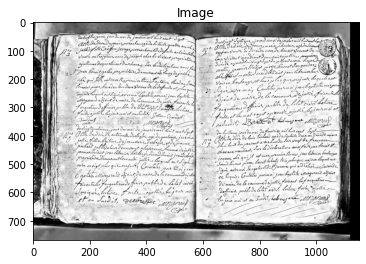

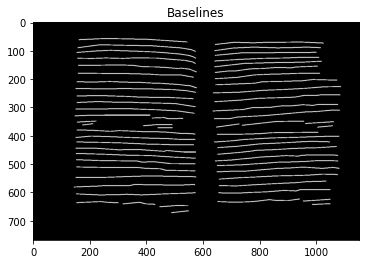

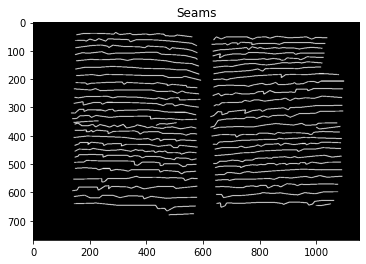

In [6]:
baseline_sequence = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines')
seam_sequence = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams')
img, baseline = baseline_sequence[0]
_, seam = seam_sequence[0]
plt.title('Image')
plt.imshow(tf.squeeze(img), cmap='gray')
plt.pause(.1)
plt.title('Baselines')
plt.imshow(tf.squeeze(baseline), cmap='gray')
plt.pause(.1)
plt.title('Seams')
plt.imshow(tf.squeeze(seam), cmap='gray')

Code that will convert data available in a Keras Sequence to TFRecord format.
TFRecord is much more efficient and allows for much faster training.

In [0]:
def create_tfrecord_from_sequence(sequence, tfrecord_path):
  print('Started writing TFRecord...')

  writer = tf.io.TFRecordWriter(tfrecord_path)

  for index, (img, label) in enumerate(sequence):
    feature = {'label': _bytes_feature(tf.io.serialize_tensor(label)),
               'image': _bytes_feature(tf.io.serialize_tensor(img))}

    example = tf.train.Example(features=tf.train.Features(feature=feature))
    writer.write(example.SerializeToString())
    if index % 1000 == 0:
      print(str(index) + '/' + str(len(sequence)))
  
  print(str(len(sequence)) + '/' + str(len(sequence)))
  
  print('Finished: TFRecord created at', tfrecord_path)

def read_tfrecord(example_proto):
  feature_description = {
      'label': tf.io.FixedLenFeature((), tf.string),
      'image': tf.io.FixedLenFeature((), tf.string)
  }

  example = tf.io.parse_single_example(example_proto, feature_description)

  image = tf.io.parse_tensor(example['image'], out_type=tf.float32)
  label = tf.io.parse_tensor(example['label'], out_type=tf.float32)

  return image, label

def _bytes_feature(value):
  """Returns a bytes_list from a string / byte."""
  if isinstance(value, type(tf.constant(0))):
    value = value.numpy() # BytesList won't unpack a string from an EagerTensor.
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a float_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value])) 

Make the actual conversion to TFRecord and store the resulting tfrecords as
*baseline.tfrecords* and *seams.tfrecords*.

In [8]:
create_tfrecord_from_sequence(BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines'), 'baseline.tfrecords')
create_tfrecord_from_sequence(BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams'), 'seams.tfrecords')

Started writing TFRecord...
0/10
10/10
Finished: TFRecord created at baseline.tfrecords
Started writing TFRecord...
0/10
10/10
Finished: TFRecord created at seams.tfrecords


Make sure we can deserialize the tfrecords file and get back an image and label

In [0]:
baseline_dataset = tf.data.TFRecordDataset('baseline.tfrecords')
seam_dataset = tf.data.TFRecordDataset('seams.tfrecords')

parsed_baseline_dataset = baseline_dataset.map(read_tfrecord)
parsed_seam_dataset = seam_dataset.map(read_tfrecord)

for baseline_features, seam_features in zip(parsed_baseline_dataset.skip(3).take(1), parsed_seam_dataset.skip(3).take(1)):
  plt.title('Image')
  plt.imshow(tf.squeeze(baseline_features[0]), cmap='gray')
  plt.pause(.1)

  plt.title('Ground Truth - Baselines')
  plt.imshow(tf.squeeze(baseline_features[1]), cmap='gray')
  plt.pause(.1)

  plt.title('Ground Truth - Seams')
  plt.imshow(tf.squeeze(seam_features[1]), cmap='gray')
  plt.pause(.1)

### Model Creation

We now create the model according to the details described in the paper.

A helper module with convolution, batch_norm, activation, dropout, and max_pool
that we'll repeatedly use in the A-Net.

In [0]:
class ConvBnActDropMp(Model):
  def __init__(self, filters, activation=L.PReLU, dropout_rate=0.0, max_pool=True, name="ConvBnActDropMp"):
    super(ConvBnActDropMp, self).__init__()

    self.model = tf.keras.Sequential(name=name)
    self.model.add(L.Conv2D(filters, kernel_size=(4, 4), padding='same'))
    self.model.add(L.BatchNormalization(renorm=True))
    self.model.add(activation())

    if dropout_rate != 0.0:
      self.model.add(L.Dropout(dropout_rate))
    
    if max_pool:
      self.model.add(L.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))

  def call(self, x):
    return self.model(x)

The residual block used in the RU-Net and the implementation of the diagram
outlined above.

In [0]:
class ResidualBlock(Model):
  def __init__(self, filters, activation=L.PReLU):
    super(ResidualBlock, self).__init__()

    self.filters = filters
    self.act_final = activation()

    self.shortcut = L.Conv2D(filters, kernel_size=(1, 1), use_bias=False)

    self.conv1 = L.Conv2D(filters, kernel_size=(3, 3), padding='same')
    self.bn1 = L.BatchNormalization(renorm=True)
    self.act1 = activation()

    self.conv2 = L.Conv2D(filters, kernel_size=(3, 3), padding='same')
    self.bn2= L.BatchNormalization(renorm=True)
    self.act2 = activation()

    self.conv3 = L.Conv2D(filters, kernel_size=(3, 3), padding='same')
    self.bn3 = L.BatchNormalization(renorm=True)
    self.act3 = activation()

    self.conv4 = L.Conv2D(filters, kernel_size=(3, 3), padding='same')

  def call(self, x):
    # Add shortcut if necessary
    if x.shape[-1] != self.filters: # Channel Dimension
      x = self.shortcut(x)
    
    # Conv1
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.act1(out)

    # Conv2
    out = self.conv2(out)
    out = self.bn2(out)
    out = self.act2(out)

    # Conv3
    out = self.conv3(out)
    out = self.bn3(out)
    out = self.act3(out)

    # Conv4 - Logits
    out = self.conv4(out)

    # Element-Wise Addition
    out = tf.math.add(out, x)

    # Final Activation
    out = self.act_final(out)

    return out

A-Net Architecture - The spatial attention mechanism that will allow the network
to focus on certain parts of the document at varying scale spaces. This is a
slight adaptation from the original paper. We are using a sigmoid instead of a
softmax.

In [0]:
class ANet(Model):
  def __init__(self, activation=L.PReLU, dropout_rate=0.2):
    super(ANet, self).__init__(name='A-Net')

    self.conv1 = ConvBnActDropMp(12, activation=activation, dropout_rate=dropout_rate, max_pool=True, name='conv1')
    self.conv2 = ConvBnActDropMp(16, activation=activation, dropout_rate=dropout_rate, max_pool=True, name='conv2')
    self.conv3 = ConvBnActDropMp(32, activation=activation, dropout_rate=dropout_rate, max_pool=True, name='conv3')
    self.conv4 = ConvBnActDropMp(2, activation=activation, dropout_rate=dropout_rate, max_pool=False, name='conv4')

  def call(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.conv4(out)

    out = tf.keras.activations.sigmoid(out)

    return out

RU-Net Architecture - The U-Net architecture with residual blocks and padding
which allow the image to have the same spatial dimensions thoughout the model.

In [0]:
class RUNet(Model):
  def __init__(self, initial_filters=8, activation=L.PReLU):
    super(RUNet, self).__init__(name='RU-Net')

    self.block1 = ResidualBlock(filters=initial_filters, activation=activation)
    self.block2 = ResidualBlock(filters=initial_filters * 2, activation=activation)
    self.block3 = ResidualBlock(filters=initial_filters * 4, activation=activation)
    self.block4 = ResidualBlock(filters=initial_filters * 8, activation=activation)
    self.block5 = ResidualBlock(filters=initial_filters * 4, activation=activation)
    self.block6 = ResidualBlock(filters=initial_filters * 2, activation=activation)
    self.block7 = ResidualBlock(filters=initial_filters, activation=activation)

    self.conv_final = L.Conv2D(filters=2, kernel_size=(1, 1), padding='same')

    self.mp1 = L.MaxPooling2D(pool_size=(2, 2), padding='same')
    self.mp2 = L.MaxPooling2D(pool_size=(2, 2), padding='same')
    self.mp3 = L.MaxPooling2D(pool_size=(2, 2), padding='same')

    self.deconv1 = L.Conv2DTranspose(initial_filters * 4, kernel_size=(2, 2), strides=(2, 2), padding='same')
    self.act1 = activation()
    self.deconv2 = L.Conv2DTranspose(initial_filters * 2, kernel_size=(2, 2), strides=(2, 2), padding='same')
    self.act2 = activation()
    self.deconv3 = L.Conv2DTranspose(initial_filters, kernel_size=(2, 2), strides=(2, 2), padding='same')
    self.act3 = activation()

  def call(self, x):
    # Down
    block1_out = self.block1(x)
    block2_in = self.mp1(block1_out)

    block2_out = self.block2(block2_in)
    block3_in = self.mp2(block2_out)

    block3_out = self.block3(block3_in)
    block4_in = self.mp3(block3_out)

    # Bottom
    block4_out = self.block4(block4_in)

    # Up
    block5_in = self.deconv1(block4_out)
    block5_in = self.act1(block5_in)
    block5_out = self.block5(tf.concat((block5_in, block3_out), axis=3))

    block6_in = self.deconv2(block5_out)
    block6_in = self.act2(block6_in)
    block6_out = self.block6(tf.concat((block6_in, block2_out), axis=3))

    block7_in = self.deconv3(block6_out)
    block7_in = self.act3(block7_in)
    block7_out = self.block7(tf.concat((block7_in, block1_out), axis=3))

    # Final Conv to get down to 1 channel
    final_out = self.conv_final(block7_out)

    return final_out

ARU-Net Architecture - The combination of the A-Net and RU-Net architectures.
Multiple ARU-Nets are used at varying scale spaces.

In [0]:
class ARUNet(Model):
  def __init__(self):
    super(ARUNet, self).__init__()

    # Scale 1 (Normal Size)
    self.anet1 = ANet()
    self.runet1 = RUNet()

    # Scale 2
    self.mp1 = L.MaxPooling2D(pool_size=(2, 2))
    self.deconv1 = L.Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(2, 2), padding='same')
    self.anet2 = ANet()
    self.runet2 = RUNet()

    # Scale 3
    self.mp2 = L.MaxPooling2D(pool_size=(2, 2))
    self.deconv2 = L.Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(4, 4), padding='same')
    self.anet3 = ANet()
    self.runet3 = RUNet()

    # Scale 4
    self.mp3 = L.MaxPooling2D(pool_size=(2, 2))
    self.deconv3 = L.Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(8, 8), padding='same')
    self.anet4 = ANet()
    self.runet4 = RUNet()

    # Scale 5
    self.mp4 = L.MaxPooling2D(pool_size=(2, 2))
    self.deconv4 = L.Conv2DTranspose(filters=1, kernel_size=(2, 2), strides=(16, 16), padding='same')
    self.anet5 = ANet()
    self.runet5 = RUNet()

    self.softmax = L.Softmax(axis=3)

  def call(self, x):
    # Scale 1
    anet1_out = self.anet1(x)
    runet1_out = self.runet1(x)
    arunet1_out = tf.math.multiply(anet1_out, runet1_out)

    # Scale 2
    x2 = self.mp1(x)
    anet2_out = self.anet2(x2)
    runet2_out = self.runet2(x2)
    arunet2_out = tf.math.multiply(anet2_out, runet2_out)
    arunet2_out = self.deconv1(arunet2_out)

    # Scale 3
    x3 = self.mp2(x2)
    anet3_out = self.anet3(x3)
    runet3_out = self.runet3(x3)
    arunet3_out = tf.math.multiply(anet3_out, runet3_out)
    arunet3_out = self.deconv2(arunet3_out)

    # Scale 4
    x4 = self.mp3(x3)
    anet4_out = self.anet4(x4)
    runet4_out = self.runet4(x4)
    arunet4_out = tf.math.multiply(anet4_out, runet4_out)
    arunet4_out = self.deconv3(arunet4_out)

    # Scale 5
    x5 = self.mp4(x4)
    anet5_out = self.anet5(x5)
    runet5_out = self.runet5(x5)
    arunet5_out = tf.math.multiply(anet5_out, runet5_out)
    arunet5_out = self.deconv4(arunet5_out)

    # Element-Wise Summation
    arunet_out = arunet1_out + arunet2_out + arunet3_out + arunet4_out + arunet5_out

    # Use sigmoid to give confidence level
    arunet_out = self.softmax(arunet_out)

    return arunet_out

Test a sample image just to make sure it works. Make a prediction (It will
likely be random noise since our model isn't trained yet).

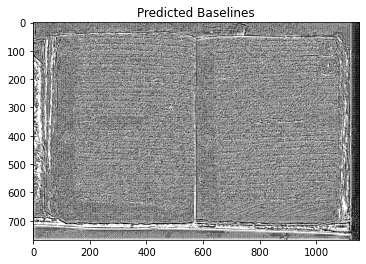

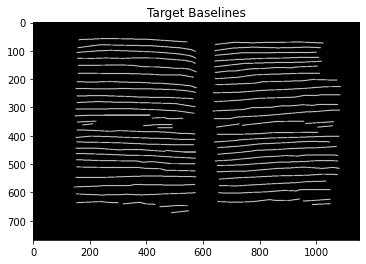

In [14]:
model = ARUNet()
x, y = baseline_sequence[0]
x = tf.expand_dims(x, 0)
out = model(x)
plt.title('Predicted Baselines')
plt.imshow(tf.argmax(tf.squeeze(out), axis=2), cmap='gray')
plt.pause(.1)
plt.title('Target Baselines')
plt.imshow(tf.squeeze(y), cmap='gray')

Let's see if we can calculate the loss and intersection over union between the
predicted and ground truth images.

In [15]:
obj = tf.keras.losses.BinaryCrossentropy()
loss = obj(y, tf.squeeze(out))

print('Loss:', loss)

Loss: tf.Tensor(3.362718, shape=(), dtype=float32)


In [16]:
iou = tf.keras.metrics.MeanIoU(num_classes=2)
iou(tf.expand_dims(y, axis=0), tf.argmax(out, axis=3))

<tf.Tensor: shape=(), dtype=float32, numpy=0.25833756>

Print a summary of the model

In [17]:
model.summary()

Model: "aru_net"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
A-Net (ANet)                 multiple                  54866608  
_________________________________________________________________
RU-Net (RUNet)               multiple                  115280514 
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr multiple                  9         
_________________________________________________________________
A-Net (ANet)                 multiple                  13726384  
_________________________________________________________________
RU-Net (RUNet)               multiple                  29018754  
_________________________________________________________________
max_pooling2d_13 (MaxPooling multiple                  0   

### Training

We now train the ARU-Net using the dataset provided above.

We place our training loop and necessary variables inside the Train
class so we avoid nasty scope issues that can occur when using
@tf.function.

In [0]:
class Train:
  def __init__(self, img_path, label_path, tfrecords_path='baseline.tfrecords', epochs=150):
    self.epochs = epochs
    self.batch_size = 1 # Paper had batch size of 1 - should increase to much more here though

    dataset_size = len(BaselineSequence(img_path=img_path, label_path=label_path))
    self.val_dataset_size = int(.4 * dataset_size)
    self.train_dataset_size = dataset_size - self.val_dataset_size

    dataset = tf.data.TFRecordDataset(tfrecords_path).map(read_tfrecord).shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    self.train_dataset = dataset.take(self.train_dataset_size).batch(self.batch_size).shuffle(buffer_size=1000, reshuffle_each_iteration=True)
    self.val_dataset = dataset.skip(self.train_dataset_size).batch(self.batch_size).shuffle(buffer_size=1000, reshuffle_each_iteration=True)

    self.model = ARUNet()
    self.optimizer = tf.keras.optimizers.RMSprop(learning_rate=4e-4)
    self.objective = tf.keras.losses.SparseCategoricalCrossentropy()

    self.train_loss = tf.keras.metrics.Mean(name='train_loss')
    self.val_loss = tf.keras.metrics.Mean(name='val_loss')
    self.train_iou = tf.keras.metrics.MeanIoU(num_classes=2, name="train_iou")
    self.val_iou = tf.keras.metrics.MeanIoU(num_classes=2, name="val_iou")

    # Learning_Rate_Decay_Per_Epoch: 0.985
    # Weight decay on L2 norm: 0.0005
    # Exponential moving average on the model weights: 0.9995

  @tf.function
  def train_step(self, images, labels):
    with tf.GradientTape() as tape:
      predictions = self.model(images)
      loss = self.objective(labels, predictions)
    
    gradients = tape.gradient(loss, self.model.trainable_variables)
    self.optimizer.apply_gradients(zip(gradients, self.model.trainable_variables))
    self.train_loss(loss)
    self.train_iou(labels, tf.argmax(predictions, axis=3))
  
  @tf.function
  def validation_step(self, images, labels):
    predictions = self.model(images)
    loss = self.objective(labels, predictions)

    self.val_loss(loss)
    self.val_iou(labels, tf.argmax(predictions, axis=3))

  def __call__(self):
    try:
      train_losses, val_losses = [], []
      train_ious, val_ious = [], []

      for epoch in range(self.epochs):
        # Reset our metrics for each epoch
        self.train_loss.reset_states()
        self.val_loss.reset_states()
        self.train_iou.reset_states()
        self.val_iou.reset_states()

        # Memory Cleanup
        gc.collect()

        # Train Step
        train_loop = tqdm(total=self.train_dataset_size//self.batch_size, position=0, leave=True)
        for images, labels in self.train_dataset:
          self.train_step(images, labels)
          train_loop.set_description('Train - Epoch: {}, Loss: {:.4f}, IoU: {:.4f}'.format(epoch, self.train_loss.result(), self.train_iou.result()))
          train_loop.update(1)
        train_loop.close()

        # Validation Step
        val_loop = tqdm(total=self.val_dataset_size//self.batch_size, position=0, leave=True)
        for images, labels in self.val_dataset:
          self.validation_step(images, labels)
          val_loop.set_description('Val   - Epoch: {}, Loss: {:.4f}, IoU: {:.4f}'.format(epoch, self.val_loss.result(), self.val_iou.result()))
          val_loop.update(1)
        val_loop.close()

        train_losses.append(self.train_loss.result())
        val_losses.append(self.val_loss.result())
        train_ious.append(self.train_iou.result())
        val_ious.append(self.val_iou.result())
    except:
      __ITB__()
    finally:
      return self.model, (train_losses, val_losses), (train_ious, val_ious)

Train the ARU-Net for Baseline-Detection.

In [0]:
train = Train('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines', tfrecords_path='baseline.tfrecords', epochs=200)
baseline_model, baseline_losses, baseline_ious = train()

Train another ARU-Net for Seam-Detection.

In [0]:
train = Train('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams', tfrecords_path='seams.tfrecords', epochs=200)
seam_model, seam_losses, seam_ious = train()

### Training Results

Function to help us plot metrics we kept track of during training.

In [0]:
def plot(title, metrics_array):
  plt.title(title)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.plot(metrics_array[0], label='Train')
  plt.plot(metrics_array[1], label='Val')
  plt.legend()
  plt.show()
  plt.pause(.1)

Graph our loss curve to see how the model learned over time.

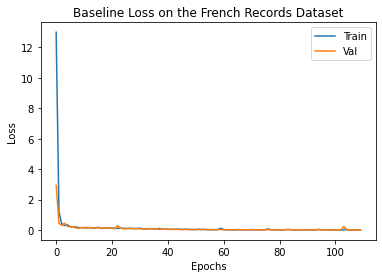

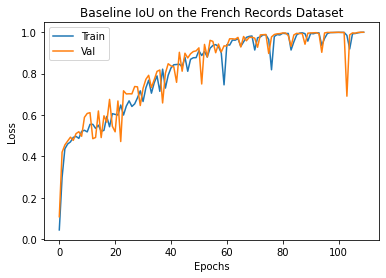

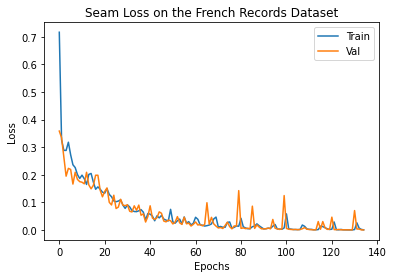

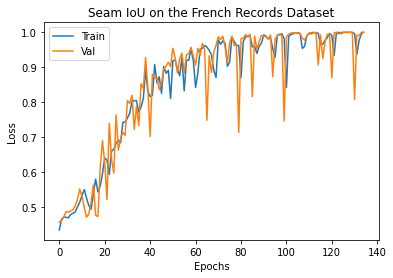

In [0]:
plot('Baseline Loss on the French Records Dataset', baseline_losses)
plot('Baseline IoU on the French Records Dataset', baseline_ious)
plot('Seam Loss on the French Records Dataset', seam_losses)
plot('Seam IoU on the French Records Dataset', seam_ious)

### Clustering

Implementation that takes output from the ARU-Net and extracts actual
baseline/seam coordinates. Note that this code is fairly slow and is a
naive implementation to extract baselines.

The paper referenced in the introduction describes a much more sophisticated
method.

In [0]:
def cluster(unclustered_confidence_array):
    sys.setrecursionlimit(10000)
    clusters = []
    i = 0
    copy_of_uca = unclustered_confidence_array.copy()
    for y in range(1, copy_of_uca.shape[0]):
        for x in range(1, copy_of_uca.shape[1]):
            if copy_of_uca[y][x] > .5:
                cluster = []
                temp = DFS(y, x, cluster, copy_of_uca)
                if len(temp) > 70:
                    bl = baseline(temp, unclustered_confidence_array)
                    clusters.append(bl)
                    # print(temp)
    # print(i)
    # print(clusters)
    return clusters

def DFS(y, x, cluster, copy_of_uca):
    cluster.append((x, y))
    copy_of_uca[y][x] = 0
    # iterate over neighbours
    for dy in range(-1, 2):
        for dx in range(-1, 2):
            if copy_of_uca[y + dy][x + dx] > .1 and \
                    (y + dy) < copy_of_uca.shape[0] and \
                    (x + dx) < copy_of_uca.shape[1]:
                cluster = DFS(y + dy, x + dx, cluster, copy_of_uca)
    return cluster

def baseline(cluster, unclustered_confidence_array):
    baseline = []
    res_list = [x[0] for x in cluster]
    for column in range(np.min(res_list), np.max(res_list) + 1):
        total_weight = 0
        total_sum = 0
        for point in cluster:
            if column == point[0]:
                # print(point, unclustered_confidence_array[point[1]][point[0]])
                total_weight += unclustered_confidence_array[point[1]][point[0]]
                total_sum += unclustered_confidence_array[point[1]][point[0]] * point[1]
        weighted_mean = int(np.round(total_sum / total_weight))
        baseline.append((column, weighted_mean))
    # print(baseline)
    return baseline


### New Clustering Method (In-Progress)

In [0]:
def cluster_new(image, min_points=10):
  # Perform clustering according to the DBSCAN algorithm
  points = tf.where(image)  # Find the coordinates that are non-zero
  clustered_points = DBSCAN(eps=2.5, min_samples=2).fit(points)

  # Create a list of lists to hold the clusters based on the labeling
  num_labels = len(np.unique(clustered_points.labels_))
  clusters = [[] for i in range(num_labels)]

  # Place points corresponding to a given label into their own list
  for label, point in zip(clustered_points.labels_, clustered_points.components_):
    if label != -1:
      clusters[label].append(point.tolist())

  # Sort the clusters from left to right
  for c in clusters:
    c.sort(key=lambda p: p[1])

  # Perform non-maximum suppression so we only have one point per column
  nms_clusters = []
  for c in clusters:  # For each cluster
    c_cluster = []
    current = -1
    for p in c:  # For each point in a cluster
      if p[1] > current:
        c_cluster.append(p)
        current = p[1]
    nms_clusters.append(c_cluster)

  # Filter out minimum points
  # nms_clusters = filter(lambda c: len(c) > min_points, nms_clusters)

  return nms_clusters

def search_up(point, image, max=25, min=4):
  y, x = point
  y_start = y

  while (image[y][x] == 0 or y_start -y < min):
    y -= 1
    if y < 0 or y_start - y > max:  # Bounds check
      break
  
  return (x, y)

def search_down(point, image, max=25, min=2):
  y_max = image.shape[0] - 1
  y, x = point
  y_start = y

  while (image[y][x] == 0 or y - y_start < min):
    y += 1
    if y > y_max or y - y_start > max:  # Bounds check
      break
  
  return (x, y)

def clean_seam_top(seam, thresh=7):
  new_seam = [seam[0]]

  previous_y = seam[0][1]
  for i in range(1, len(seam)):  # Skip the first
    if seam[i][1] - previous_y < thresh:
      new_seam.append(seam[i])
      previous_y = seam[i][1]
  
  return new_seam

def clean_seam_bottom(seam, thresh=7):
  new_seam = [seam[0]]

  previous_y = seam[0][1]
  for i in range(1, len(seam)):  # Skip the first
    if np.abs(previous_y - seam[i][1]) < thresh:
      new_seam.append(seam[i])
      previous_y = seam[i][1]

  return new_seam

def clean_seam(seam, thresh=7):
  new_seam = [seam[0]]

  previous_y = seam[0][1]
  for i in range(1, len(seam)):
    if np.abs(previous_y - seam[i][1]) < thresh:
      new_seam.append(seam[i])
      previous_y = seam[i][1]
    
  return new_seam

In [92]:
np.where(seam_image2 > .3, 1, 0)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

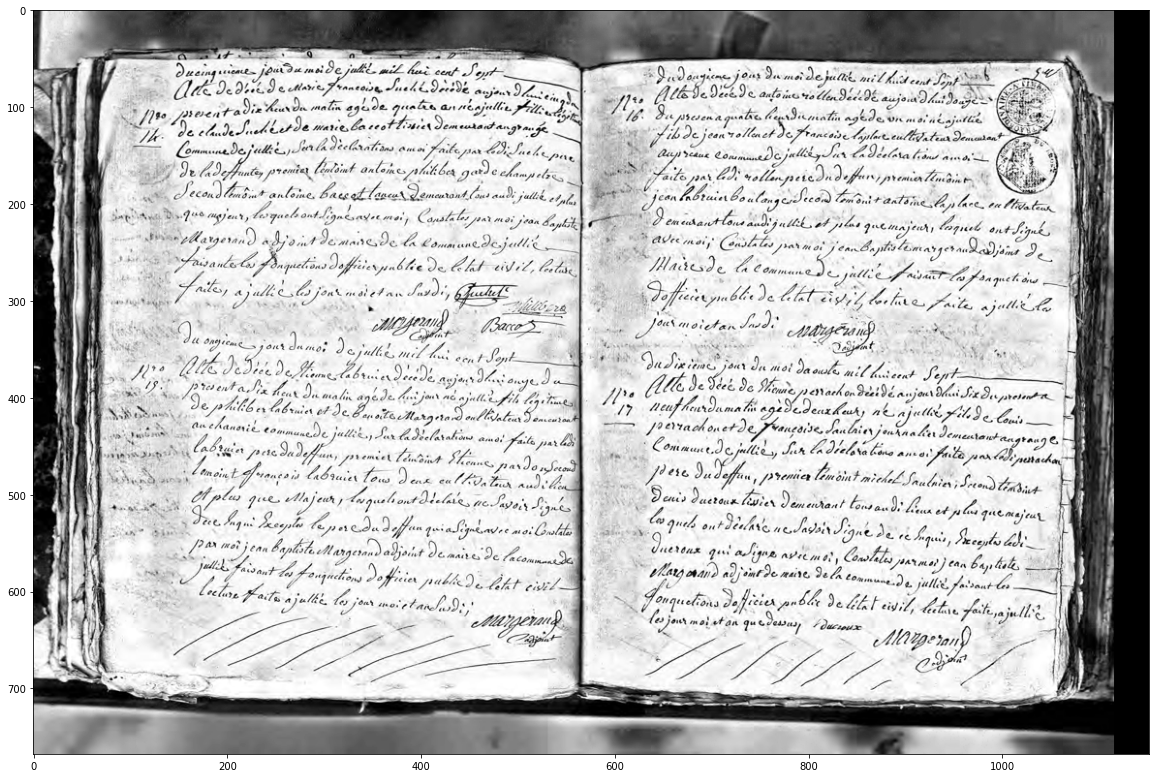

In [347]:
plt.figure(figsize=(20,20))
plt.imshow(original_image, cmap='gray')

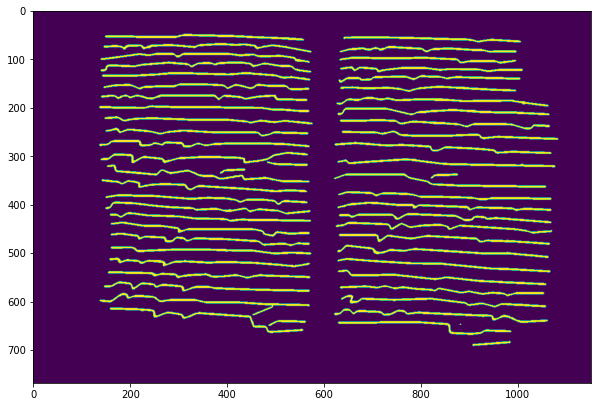

In [344]:
from scipy.ndimage.filters import gaussian_filter, median_filter

# blurred = median_filter(seam_image, size=2)
# plt.figure(figsize=(10,10))
# plt.imshow(blurred)
# plt.pause(.1)
seam_image2= tf.squeeze(seam_predictions[:,:,:,1]).numpy()
seam_image2 = np.where(seam_image2>.10, 1, 0)
seam_image2 = median_filter(seam_image2, size=4)
seam_image2 = median_filter(seam_image2, size=4)
seam_image2 = median_filter(seam_image2, size=3)
seam_image2 = np.where(seam_image2>.9, 1, 0)

plt.figure(figsize=(10,10))
plt.imshow(seam_image2)
plt.pause(.1)

In [345]:
start = time.perf_counter()
baselines = cluster_new(baseline_image)
print(time.perf_counter() - start)

start2 = time.perf_counter()
polygons = []
for baseline in baselines:
  seam_top = []
  seam_bottom = []
  for index, point in enumerate(baseline):
    if index % 1 == 0:
      seam_top.append(search_up(point, seam_image2))
      seam_bottom.append(search_down(point, seam_image2))
  
  # seam_top = clean_seam_top(seam_top)
  # seam_bottom = clean_seam_bottom(seam_bottom)
  polygons.append(np.concatenate((seam_top, seam_bottom[::-1])))

print(time.perf_counter() - start2)

0.5152986650000457
0.2914960580001207


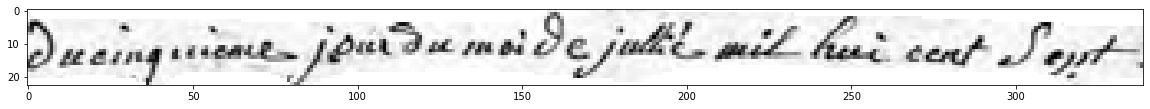

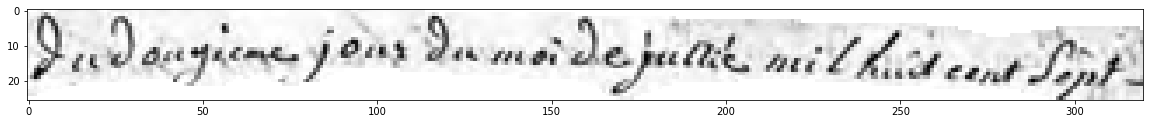

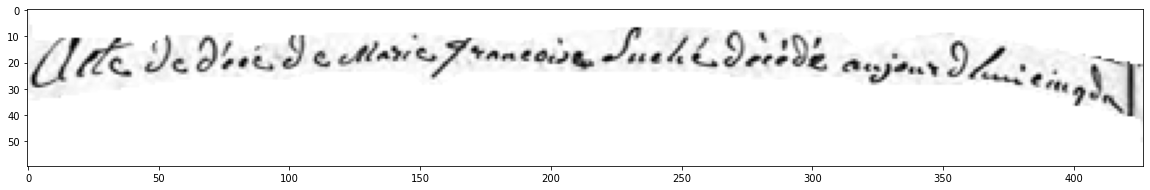

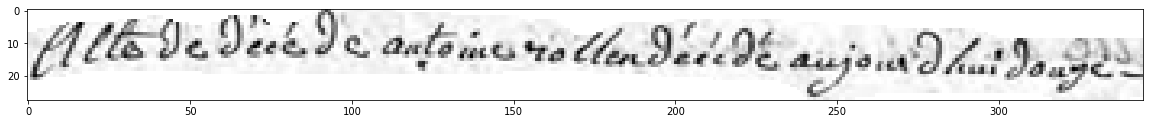

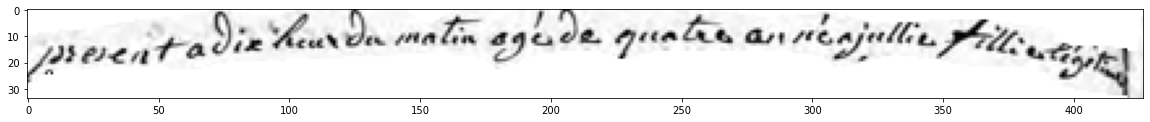

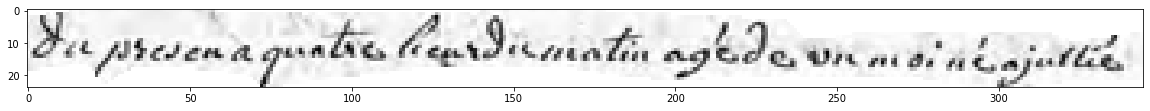

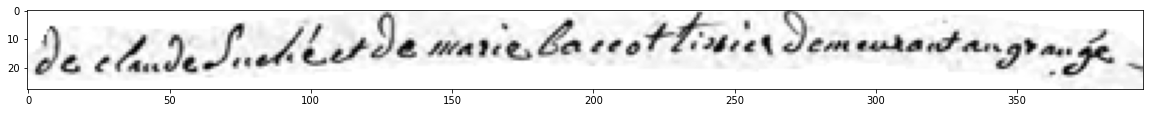

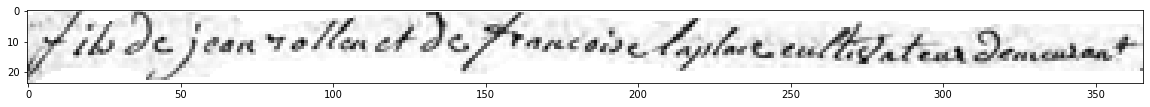

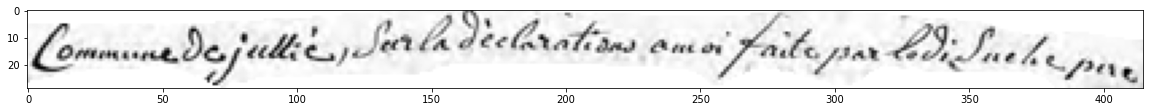

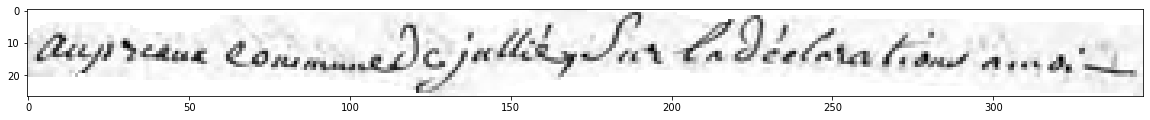

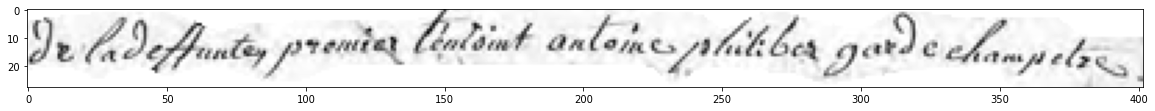

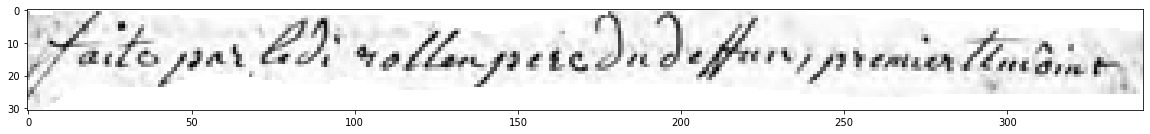

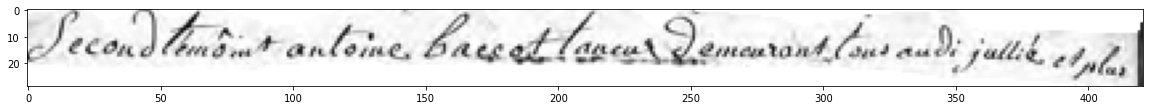

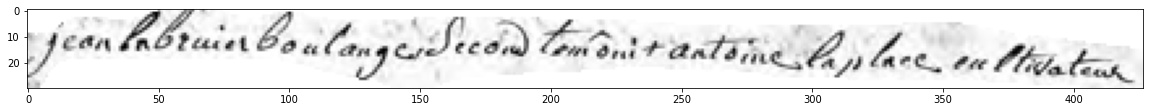

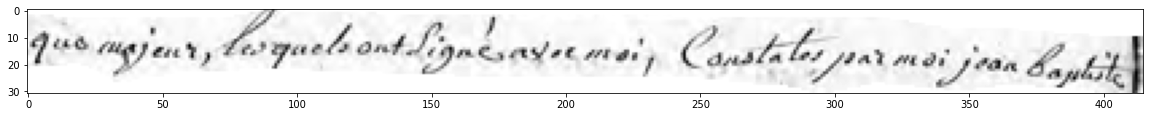

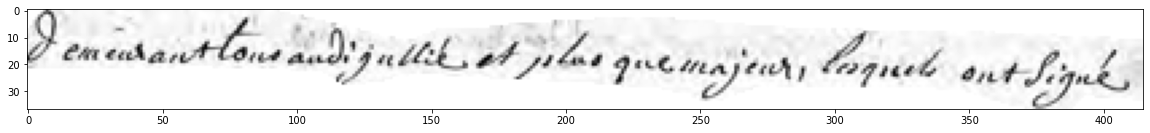

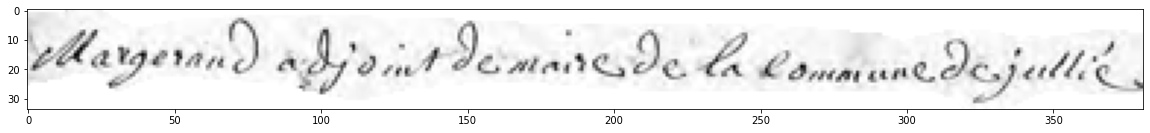

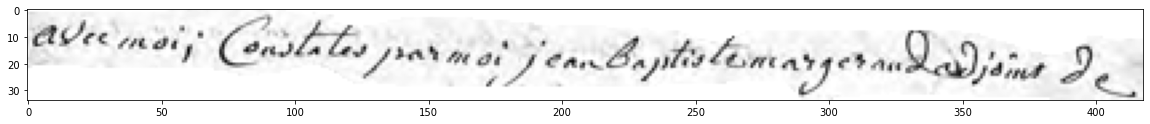

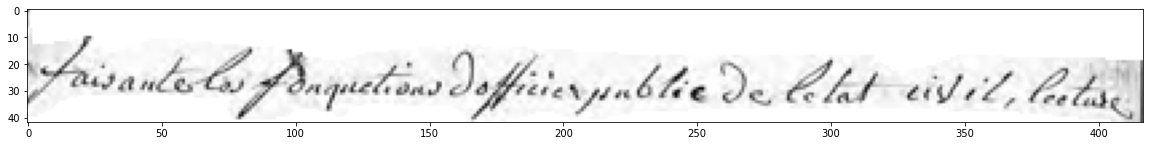

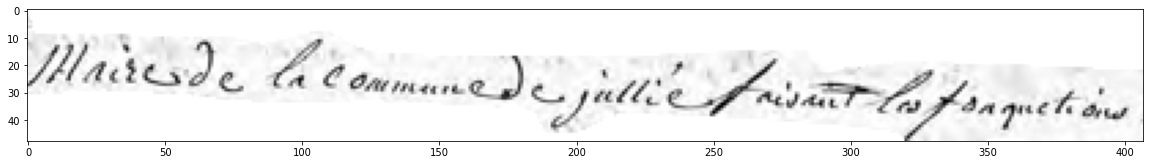

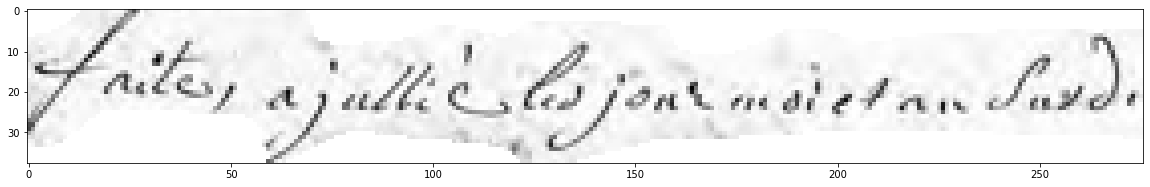

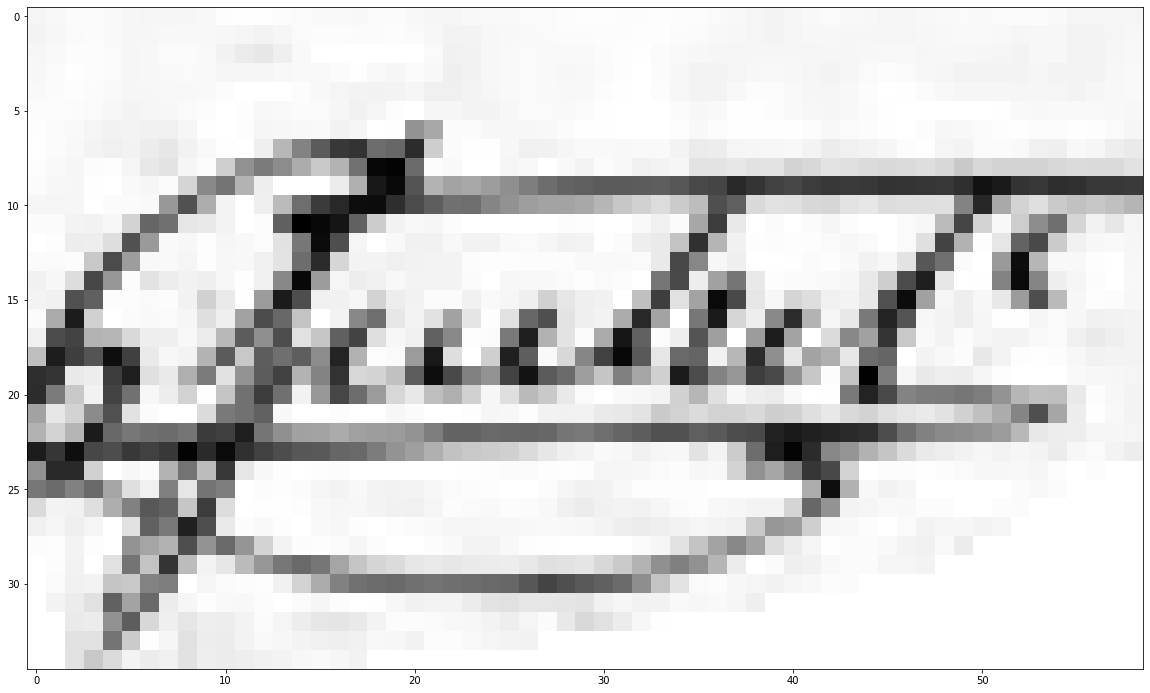

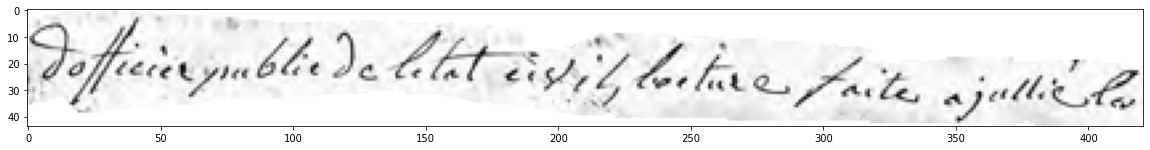

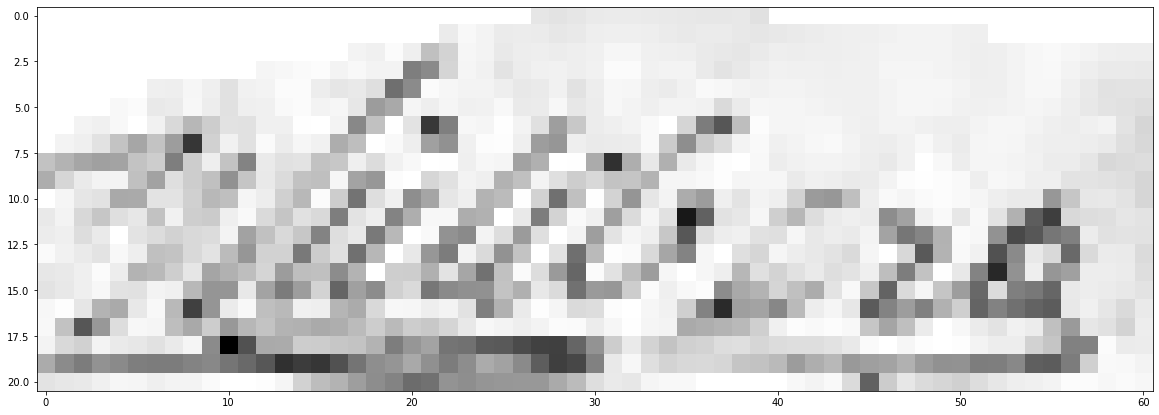

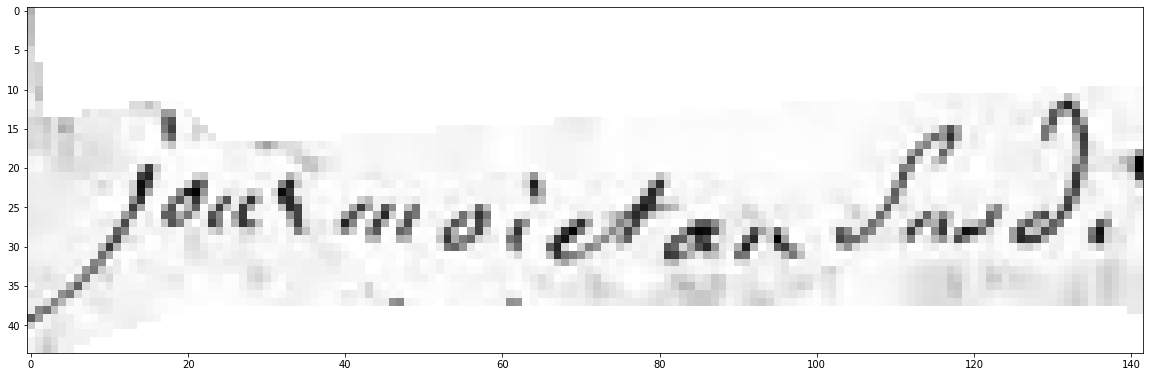

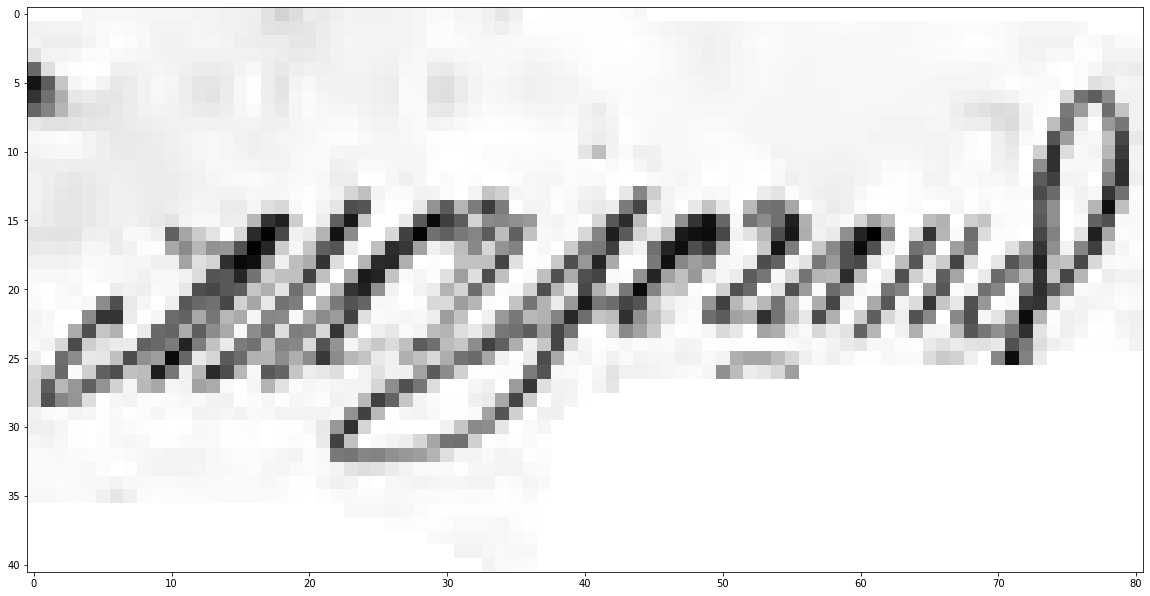

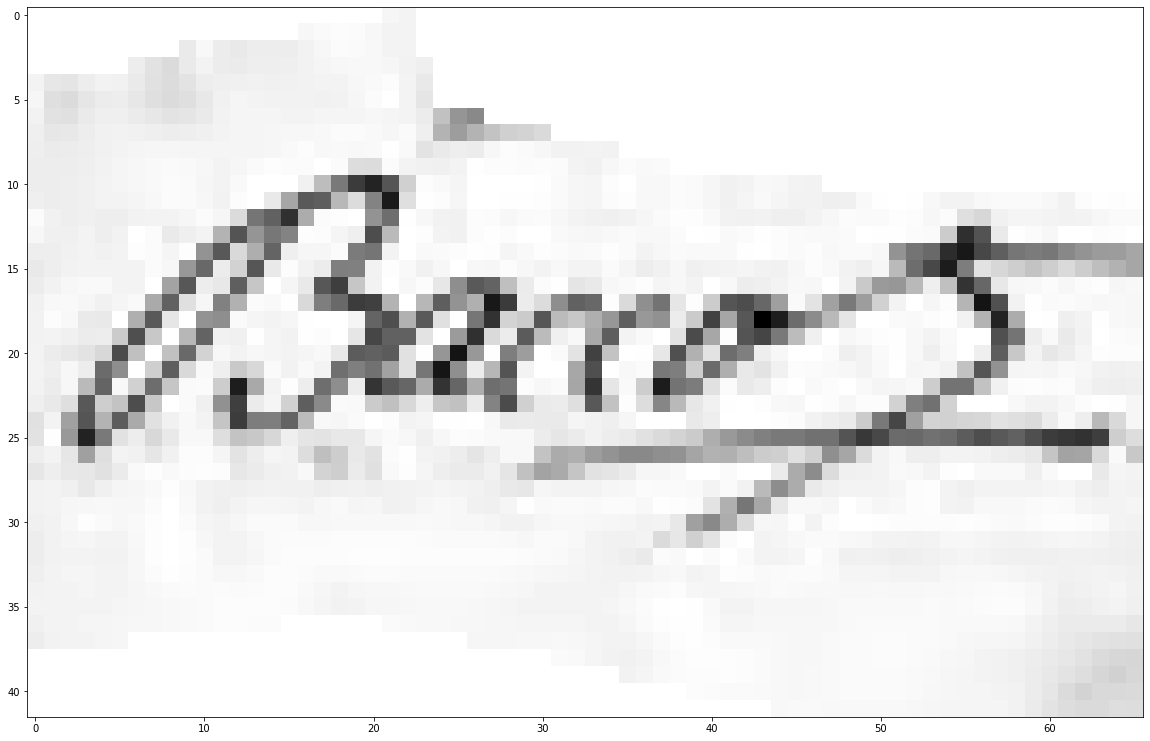

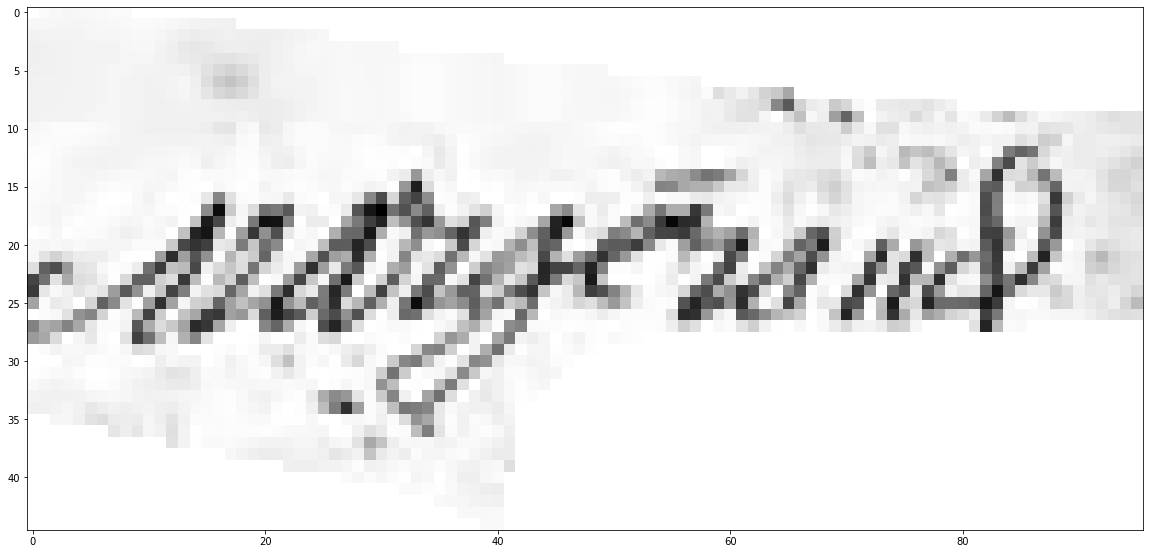

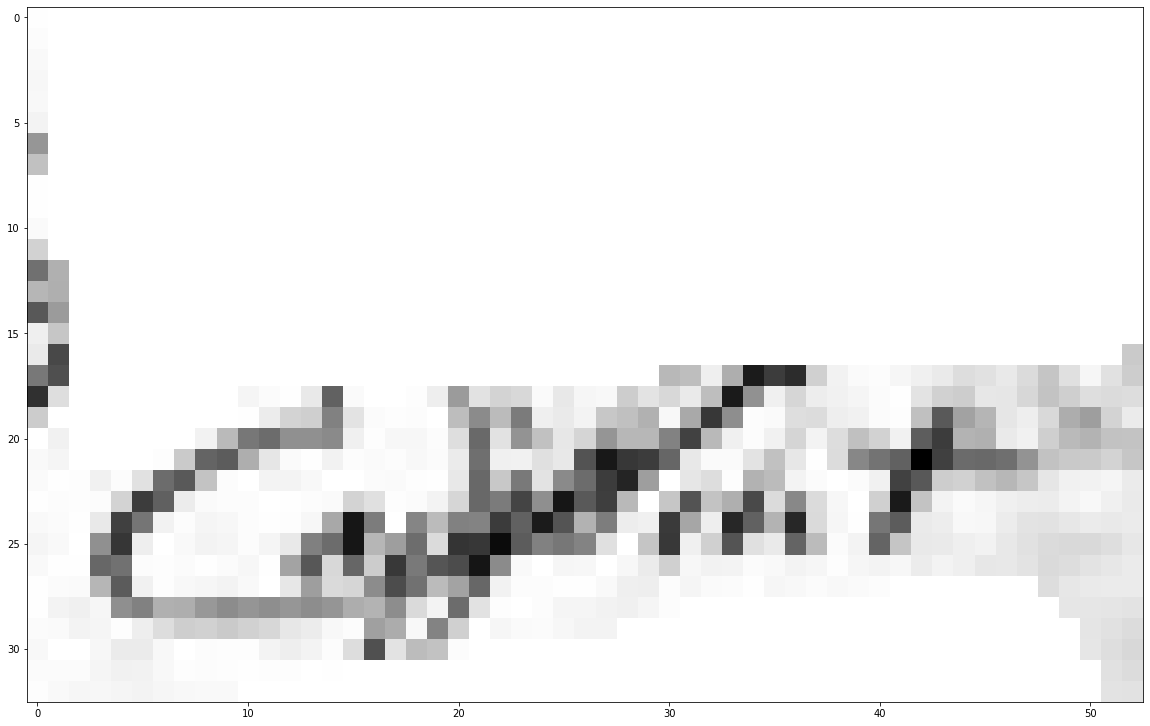

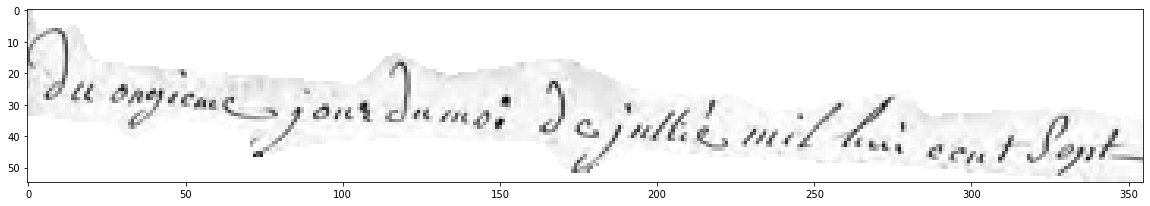

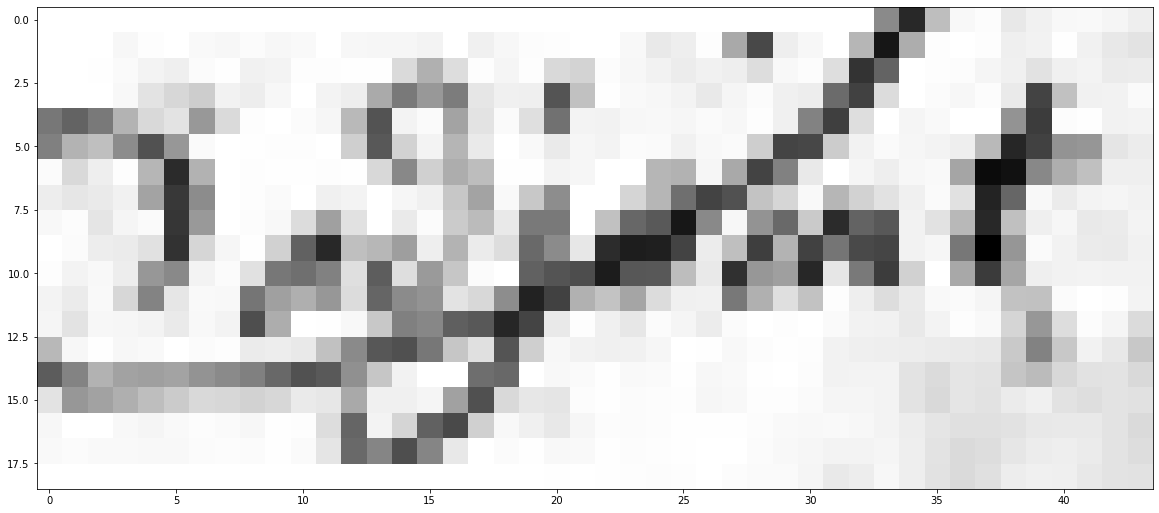

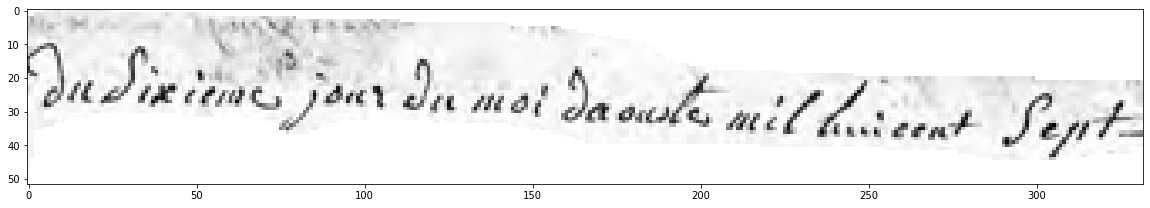

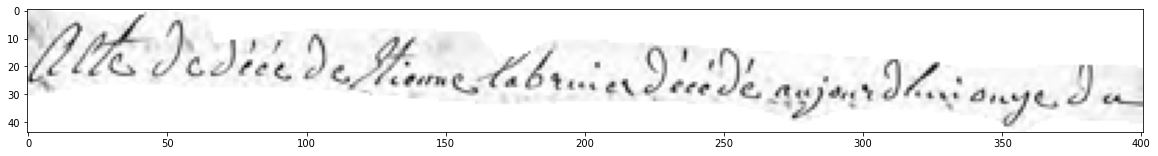

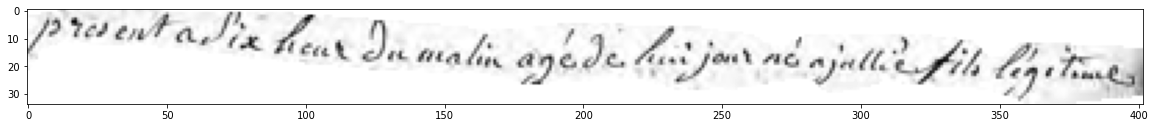

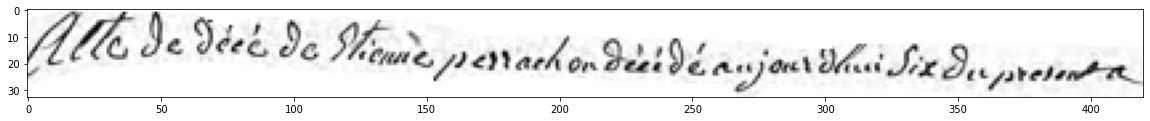

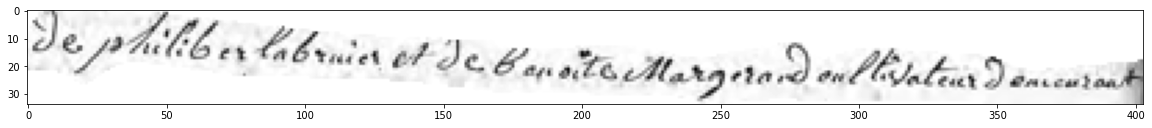

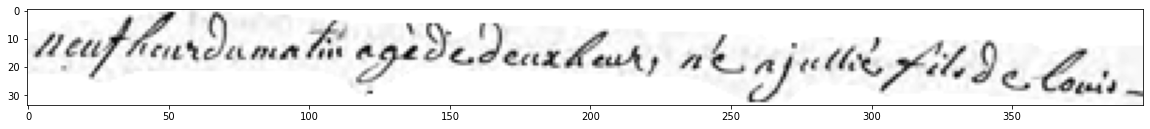

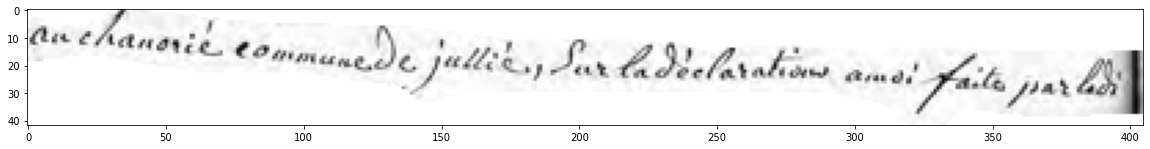

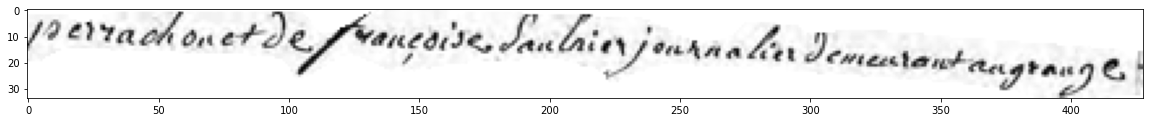

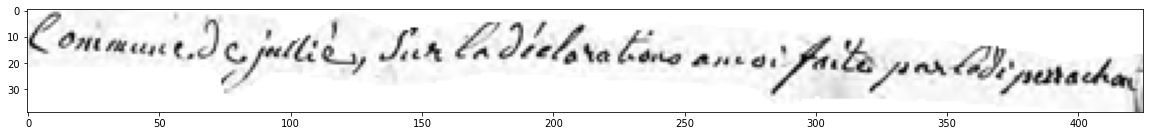

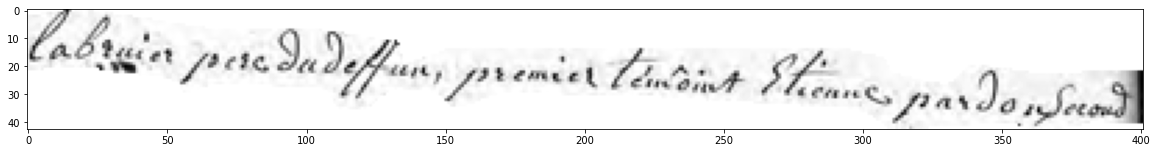

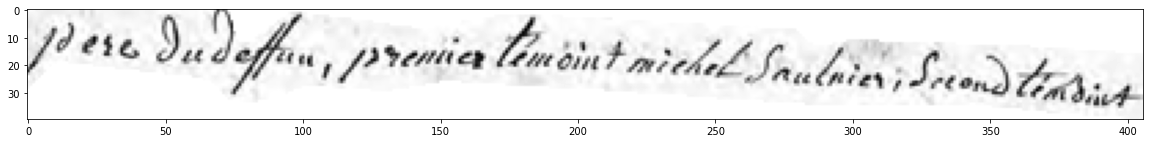

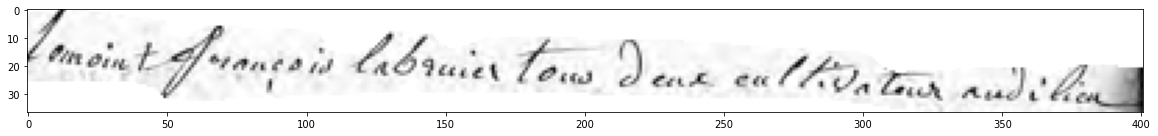

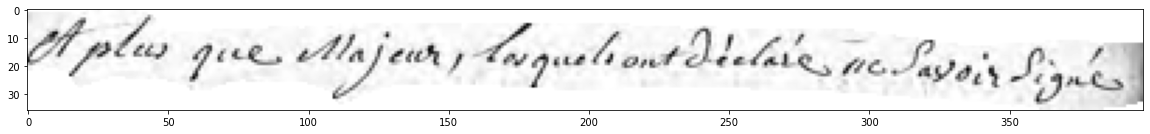

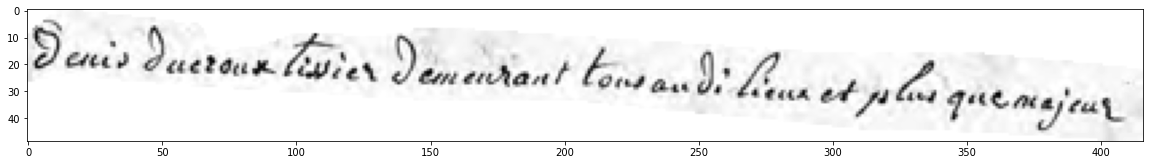

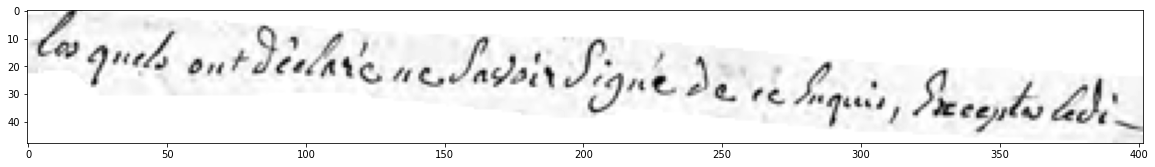

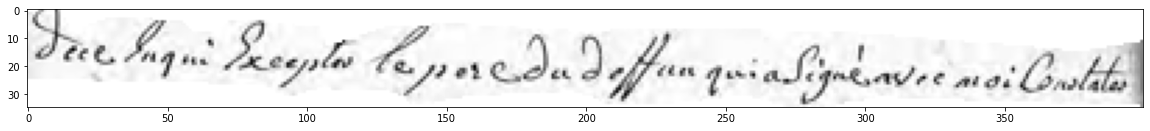

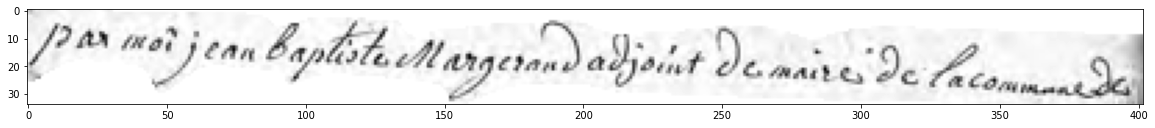

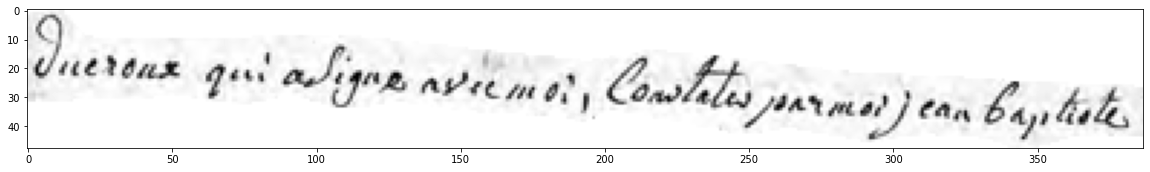

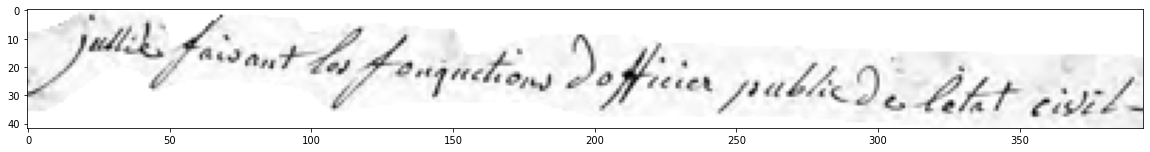

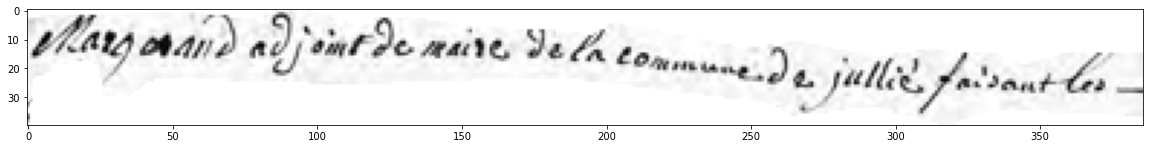

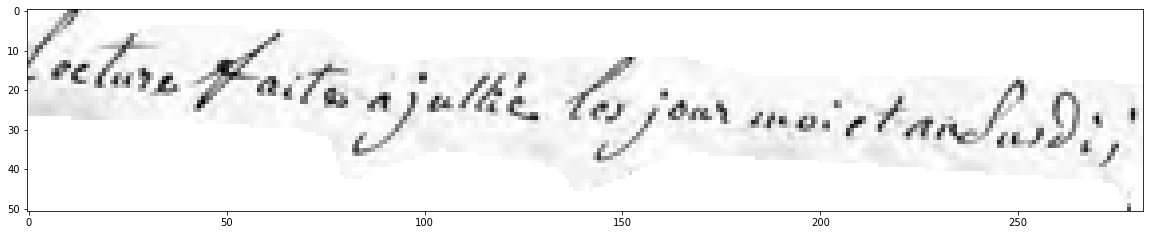

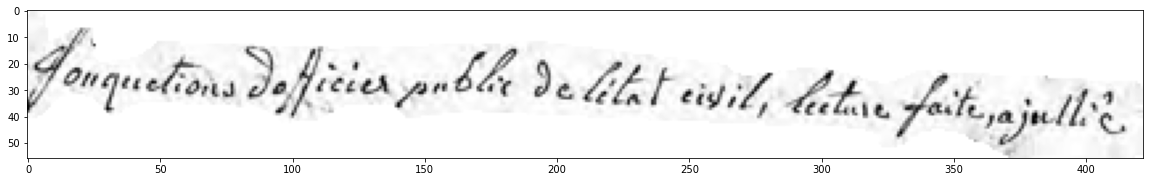

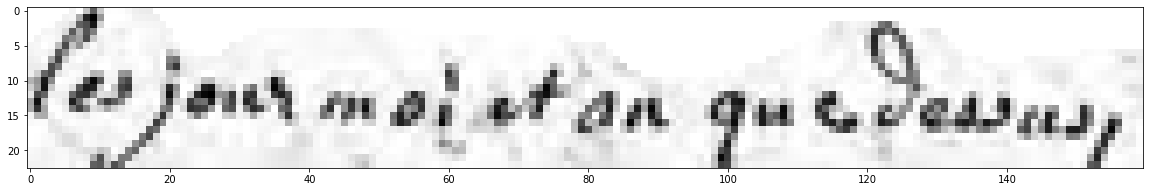

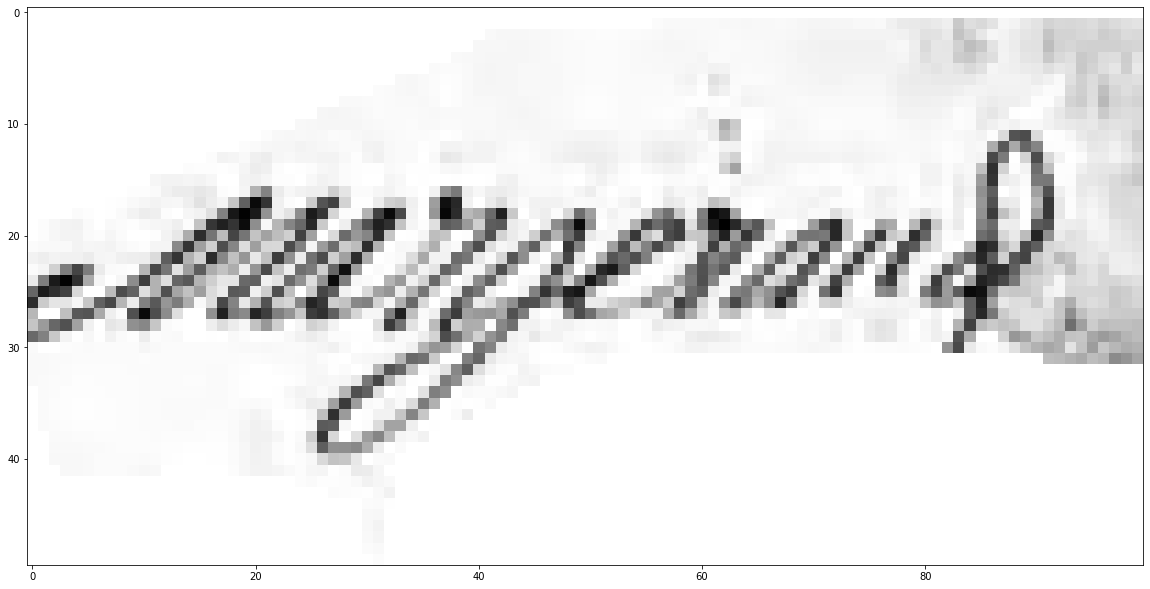

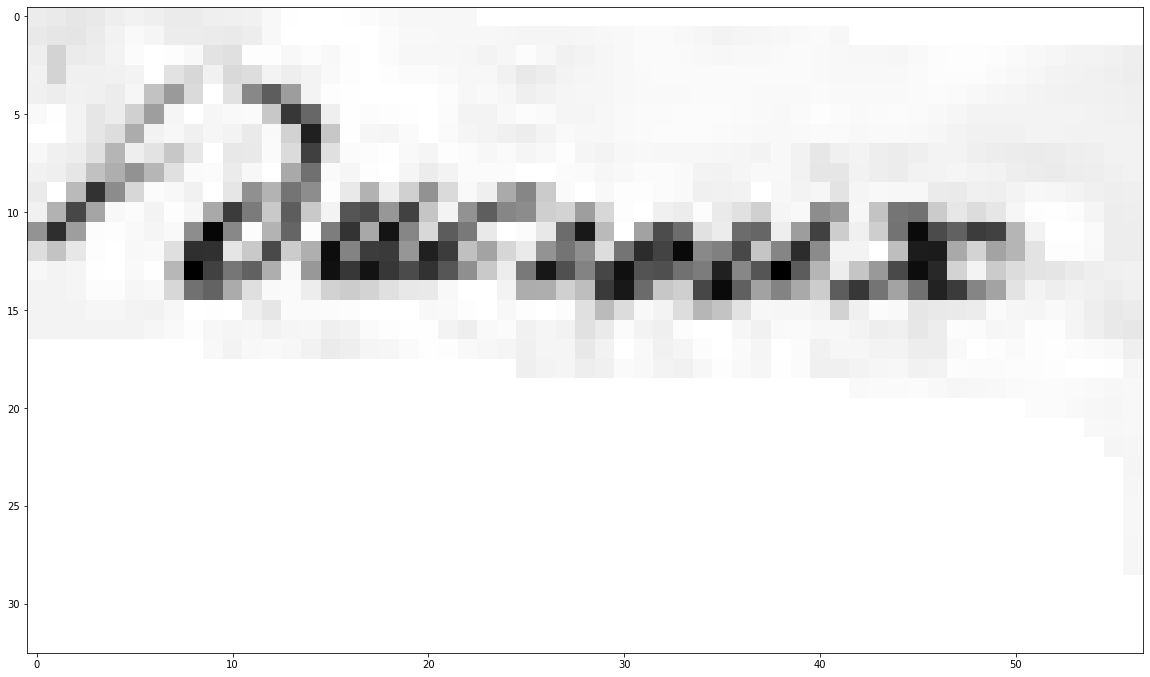

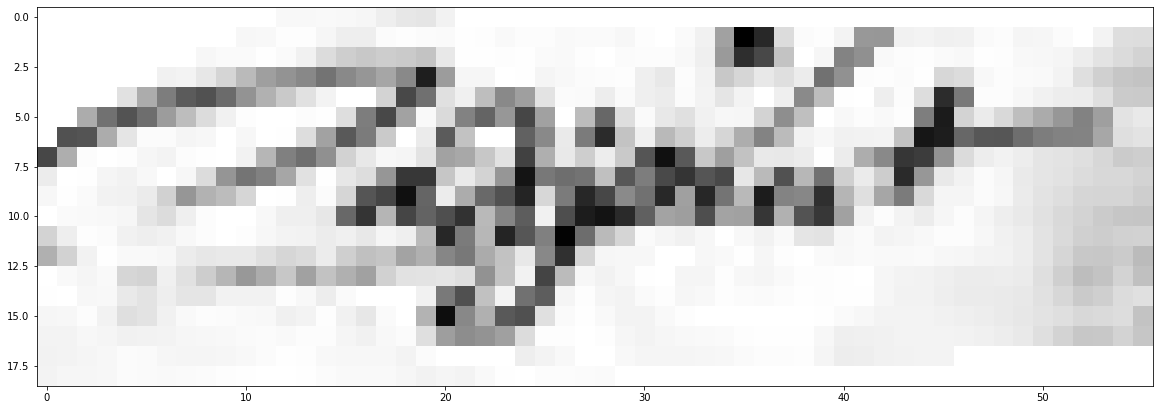

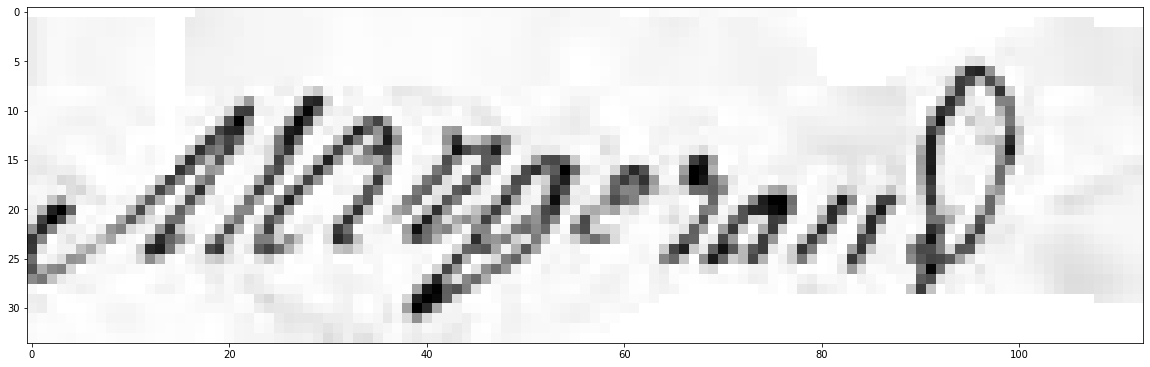

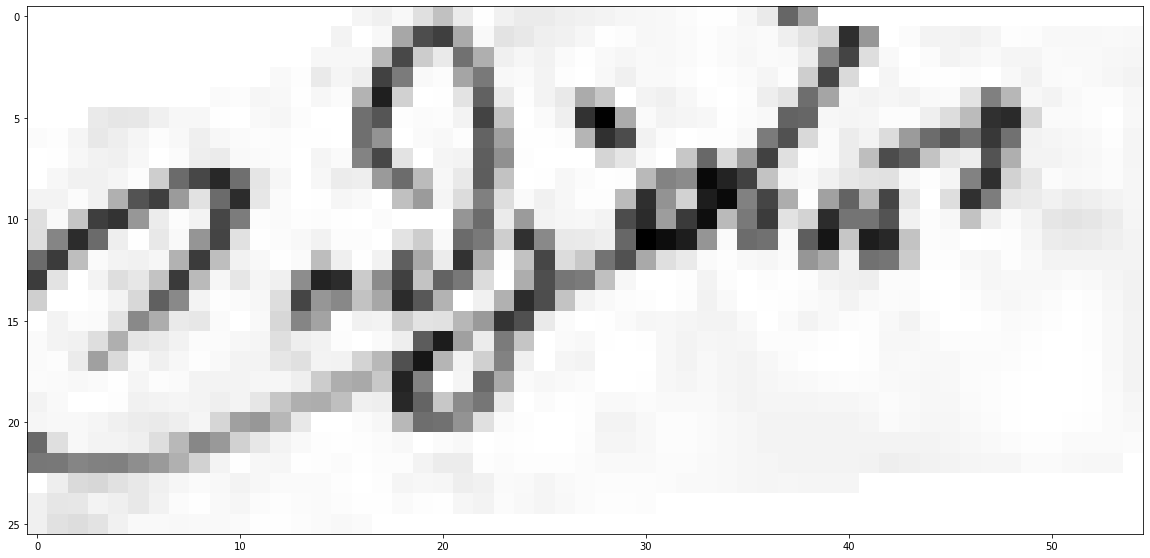

In [346]:
for poly in polygons:
  segment = segment_from_polygon(Polygon(poly), Image.fromarray(original_image))
  plot_image(segment)

### Example Predictions

Load pretrained models if desired.

In [21]:
from google.colab import drive
drive.mount('/content/drive')

!cp -r '/content/drive/My Drive/arunet_baselines' '/content/arunet_baselines'
!cp -r '/content/drive/My Drive/arunet_seams' '/content/arunet_seams'

baseline_model = ARUNet()
seam_model = ARUNet()
baseline_model.load_weights('/content/arunet_baselines/run1')
seam_model.load_weights('/content/arunet_seams/run1')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


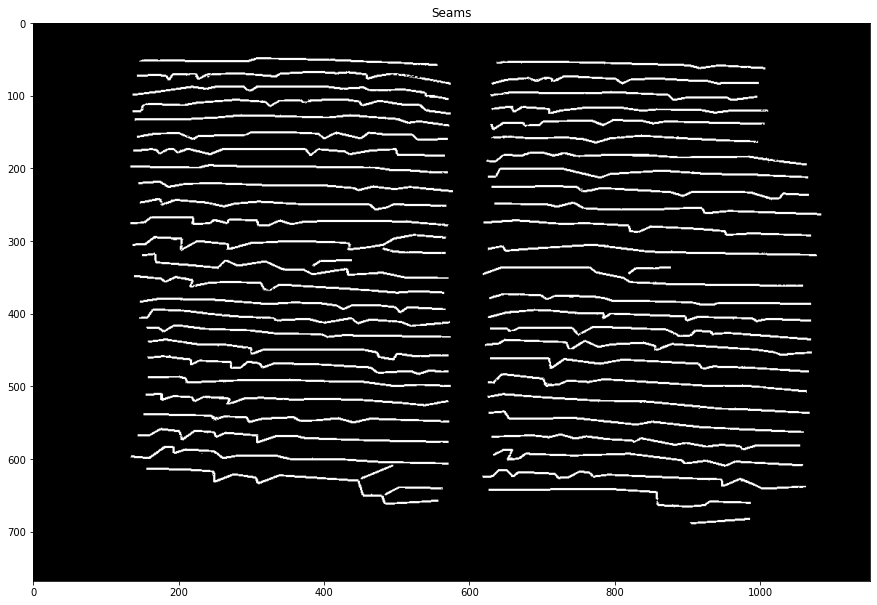

In [343]:
image, baseline_image = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines')[1]
_, seam_image = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams')[1]

baseline_predictions = baseline_model(tf.expand_dims(image, axis=0))
seam_predictions = seam_model(tf.expand_dims(image, axis=0))

original_image = tf.squeeze(image).numpy()
baseline_image = tf.squeeze(tf.argmax(baseline_predictions, axis=3)).numpy()
seam_image = tf.squeeze(tf.argmax(seam_predictions, axis=3)).numpy()

# plt.figure(figsize=(15,15))
# plt.title('Baselines')
# plt.imshow(baseline_image, cmap='gray')
# plt.pause(.1)

plt.figure(figsize=(15,15))
plt.title('Seams')
plt.imshow(seam_image, cmap='gray')
# print(baseline_image)
# print(seam_image)

Show our predictions for baselines and seams.

In [23]:
image, baseline_image = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines')[0]
_, seam_image = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams')[0]

baseline_predictions = baseline_model(tf.expand_dims(image, axis=0))
seam_predictions = seam_model(tf.expand_dims(image, axis=0))

original_image = tf.squeeze(image).numpy()
baseline_image = tf.argmax(tf.squeeze(baseline_predictions), axis=2).numpy()
seam_image = tf.argmax(tf.squeeze(seam_predictions), axis=2).numpy()

# plt.figure(figsize=(20,20))
# plt.title('Predicted Seams')
# plt.imshow(seam_image, cmap='gray')
# plt.pause(.1)

print('Calculating baselines from ARU-Net output image...')
baseline_clusters = cluster_new(baseline_image)
print('Calculating seams from ARU-Net output image...')
seam_clusters = cluster_new(seam_image)

baseline_image = Image.fromarray(original_image)
seam_image = Image.fromarray(original_image)

baseline_draw = ImageDraw.Draw(baseline_image)
for cluster_line in baseline_clusters:
  baseline_draw.line(cluster_line, fill=1, width=2)

seam_draw = ImageDraw.Draw(seam_image)
for cluster_line in seam_clusters:
  seam_draw.line(cluster_line, fill=1, width=2) 

plt.figure(figsize=(20,20))
plt.title('Predicted Baselines')
plt.imshow(baseline_image, cmap='gray')
plt.pause(.1)
plt.figure(figsize=(20,20))
plt.title('Predicted Seams')
plt.imshow(seam_image, cmap='gray')
plt.pause(.1)

Calculating baselines from ARU-Net output image...
Calculating seams from ARU-Net output image...


SystemError: ignored

Save the weights to our model and copy them to Google Drive if desired.

In [0]:
baseline_model.save_weights('arunet_baselines/run1')
seam_model.save_weights('arunet_seams/run1')

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!cp -r 'arunet_baselines/' '/content/drive/My Drive/'
!cp -r 'arunet_seams/' '/content/drive/My Drive/'

### Segmentation

Code to actually segment images from baseline and seam images.

In [0]:
def create_segments(original_image, baseline_image, seam_image, image_name, save_images=True, plot_images=False): # Expects Numpy arrays in image format
  print('Calculating baselines from baseline output image...')
  baseline_cluster = cluster(baseline_image)
  print('Calculating seams from seam output image...')
  seam_cluster = cluster(seam_image)

  seams = [LineString(s) for s in seam_cluster]

  for bl in baseline_cluster:
    first_point = Point(bl[0])
    # Consider giving points that aren't right next to each other to create perp line
    first_perp = get_perpendicular_line(LineString(bl[0:2][::-1]), 2000)
    last_point = Point(bl[-1])
    last_perp = get_perpendicular_line(LineString(bl[-2:]), 2000)

    mid_point_index = len(bl) // 2
    mid_point =  Point(bl[mid_point_index])
    mid_perp = get_perpendicular_line(LineString(bl[mid_point_index:mid_point_index + 2]), 2000)

    top_seam, bottom_seam = find_closest_seams(first_point, mid_point, last_point, first_perp, mid_perp, last_perp, seams)

    polygon_points = []
    for coord in top_seam:
      polygon_points.append(coord)
    
    for coord in bottom_seam[::-1]:
      polygon_points.append(coord)

    poly = Polygon(polygon_points)

    image_snippet = segment_from_polygon(poly, Image.fromarray(original_image))
    image_snippet_name = '{}_{}_{}.jpg'.format(image_name, str(int(polygon_points[0][0])), str(int(polygon_points[0][1])))

    if save_images:
      save_image(image_snippet, image_snippet_name)
    if plot_images:
      plot_image(image_snippet, title=image_snippet_name)

In [75]:
l = LineString([(0,0), (10,0), (15,0)])
p = Point((5,7))
print(p.coords.xy[0][0])
print(p.coords.xy[1][0])

5.0
7.0


In [0]:
def find_closest_seams(first_point, mid_point, last_point, beg_perp, mid_perp, end_perp, seams):
  distances_seams = []
  for s in seams:
    if mid_perp.intersects(s):
      intersection = s.intersection(mid_perp)
      if type(intersection) is not Point:
        intersection = intersection[0]
      
      distances_seams.append((s.distance(mid_point), intersection.coords[0], s))

  top_dist = None
  top_seam = None
  bottom_dist = None
  bottom_seam = None

  for dist, intersect, seam in distances_seams:
    if is_above(mid_point.coords[0], intersect):
      if top_dist is None or top_dist > dist:
        top_seam = seam
        top_dist = dist
    else:
      if bottom_dist is None or bottom_dist > dist:
        bottom_seam = seam
        bottom_dist = dist

  # Create default seams if none were found
  if top_seam is None:
    # Create straight horizontal line above the baseline with beg/end points
    first = (first_point.coords.xy[0][0], first_point.coords.xy[1][0] - 15)
    mid = (mid_point.coords.xy[0][0], mid_point.coords.xy[1][0] - 15)
    last = (last_point.coords.xy[0][0], last_point.coords.xy[1][0] - 15)
    top_seam = LineString([first, mid, last])
  if bottom_seam is None:
    # Create straight horizontal line above the baseline with beg/end points
    first = (first_point.coords.xy[0][0], first_point.coords.xy[1][0] + 15)
    mid = (mid_point.coords.xy[0][0], mid_point.coords.xy[1][0] + 15)
    last = (last_point.coords.xy[0][0], last_point.coords.xy[1][0] + 15)
    bottom_seam = LineString([first, mid, last])   

  # print(top_seam)
  # print(bottom_seam)

  # Find our intersection points with the above/below seams
  # If we don't quite intersect, create extra points, expand the seam so we can intersect

  # Top-Left
  if beg_perp.intersects(top_seam):
    intersection = beg_perp.intersection(top_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]
    top_left_intersect = Point(intersection.coords[0])
  else:
    left_most_seam_point = top_seam.coords[0]
    new_point_to_add = (first_point.coords[0][0], left_most_seam_point[1])
    top_seam = add_point_to_seam(top_seam, new_point_to_add)
    top_left_intersect = Point(new_point_to_add)

  # Bottom-Left
  if beg_perp.intersects(bottom_seam):
    intersection = beg_perp.intersection(bottom_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]

    bottom_left_intersect = Point(intersection.coords[0])
  else:
    left_most_seam_point = bottom_seam.coords[0]
    new_point_to_add = Point(first_point.coords[0][0], left_most_seam_point[1])
    bottom_seam = add_point_to_seam(bottom_seam, new_point_to_add)
    bottom_left_intersect = Point(new_point_to_add)

  # Top-Right
  if end_perp.intersects(top_seam):
    intersection = end_perp.intersection(top_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]
    top_right_intersect = Point(intersection.coords[0])
  else:
    right_most_seam_point = top_seam.coords[-1]
    new_point_to_add = Point(last_point.coords[0][0], right_most_seam_point[1])
    top_seam = add_point_to_seam(top_seam, new_point_to_add, beginning=False)
    top_right_intersect = Point(new_point_to_add)

  # Bottom-Right 
  if end_perp.intersects(bottom_seam):
    intersection = end_perp.intersection(bottom_seam)
    if type(intersection) is not Point:
      intersection = intersection[0]
    bottom_right_intersect = Point(intersection.coords[0])
  else:
    right_most_seam_point = bottom_seam.coords[-1]
    new_point_to_add = Point(last_point.coords[0][0], right_most_seam_point[1])   
    bottom_seam = add_point_to_seam(bottom_seam, new_point_to_add, beginning=False)
    bottom_right_intersect = Point(new_point_to_add)

  top_seam = split_seam(top_seam, top_left_intersect, top_right_intersect)
  bottom_seam = split_seam(bottom_seam, bottom_left_intersect, bottom_right_intersect)

  return top_seam, bottom_seam

# Change this code to handle exactly vertical lines
def is_above(point, seam_point):
  if point[1] > seam_point[1]:
    return True
  else:
    return False

def get_perpendicular_line(line: LineString, length: int):
    left = line.parallel_offset(length / 2, 'left')
    right = line.parallel_offset(length / 2, 'right')
    point1 = left.boundary[1]
    point2 = right.boundary[0]

    return LineString([point1, point2])

def split_seam(seam, left_point, right_point):
  result = split(seam, left_point)

  # This statement is required in the event that the intersection is the first point in the seam LineString
  if len(result) > 1:
    first_split = LineString(result[1].coords[:])
  else:
    first_split = LineString(result[0].coords[:])

  result = split(first_split, right_point)
  final_split = result[0].coords[:]

  return final_split

def add_point_to_seam(seam, new_point, beginning=True):
  seam_coords = seam.coords[:]
  if beginning:
    seam_coords.insert(0, new_point)
  else:
    seam_coords.append(new_point)

  return LineString(seam_coords)

def save_image(img, path):
  if not os.path.exists(path):
    os.makedirs(path)
  
  img = Image.fromarray(img)
  img.save(path)

def plot_image(img, title=None, figsize=(20,20)):
  plt.figure(figsize=figsize)
  if title is not None:
    plt.title(title)
  plt.imshow(img, cmap='gray')
  plt.pause(.1)

def segment_from_polygon(polygon: Polygon, original_image):
  poly_coords = polygon.exterior.coords[:]
  bounds = polygon.bounds

  blank_img = Image.new("L", original_image.size, 255)
  mask = Image.new("1", original_image.size, 0)
  poly_draw = ImageDraw.Draw(mask)
  poly_draw.polygon(poly_coords, fill=255)

  new_img = Image.composite(original_image, blank_img, mask)
  new_img_cropped = np.array(new_img)[int(bounds[1]):int(bounds[3]), int(bounds[0]):int(bounds[2])]

  return new_img_cropped

### Segmentation Results

Grab an image from the dataset.

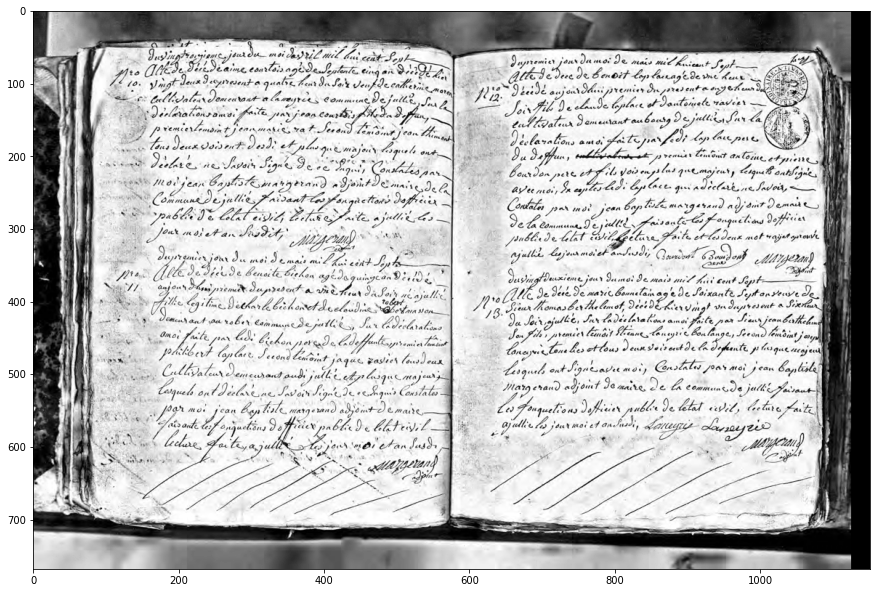

In [77]:
image, baseline_image = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/baselines')[0]
_, seam_image = BaselineSequence('/content/baseline_seams_dataset/images', '/content/baseline_seams_dataset/seams')[0]

plt.figure(figsize=(15,15))
plt.imshow(tf.squeeze(image), cmap='gray')

Predict the baselines, seams, and create line-level snippets based on the
output.

Predicting Baselines...
Predicting Seams...
Analyzing baseline and seam images for segmentation...
Calculating baselines from baseline output image...
Calculating seams from seam output image...


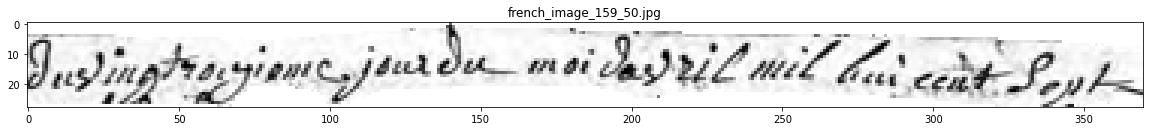

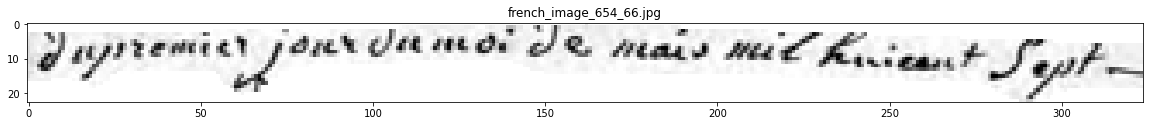

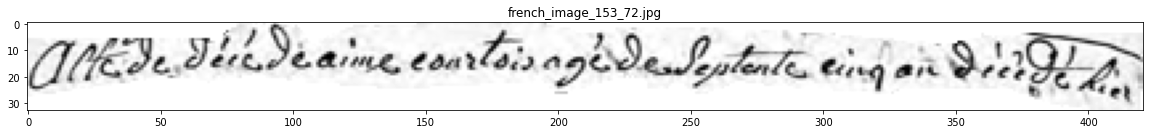

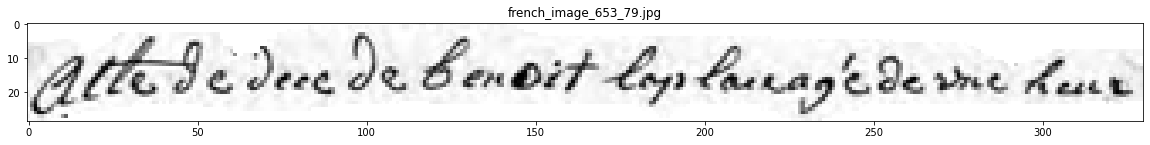

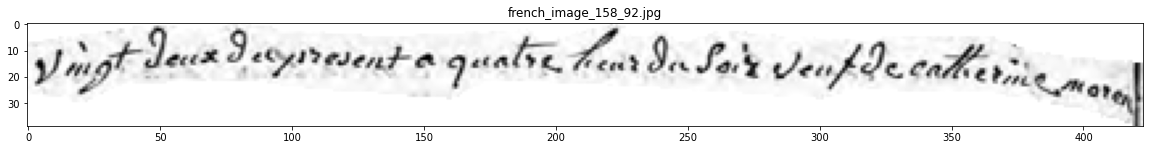

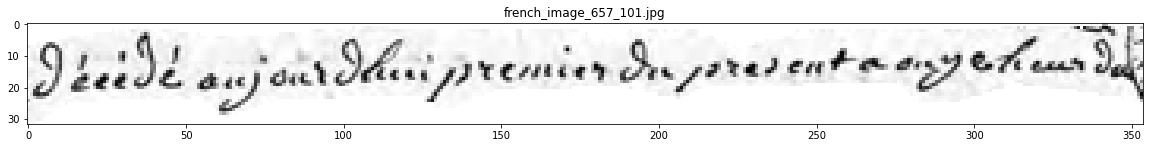

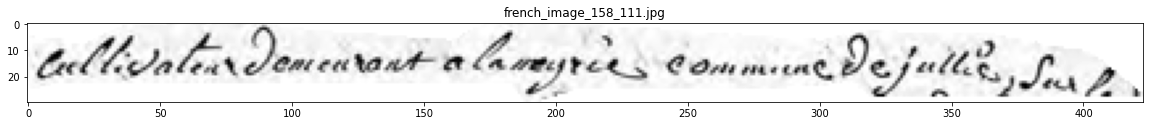

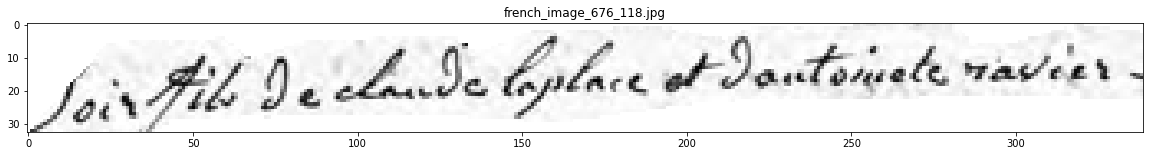

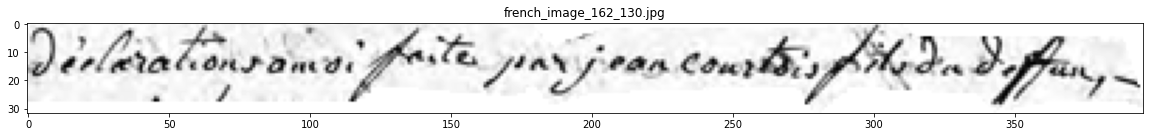

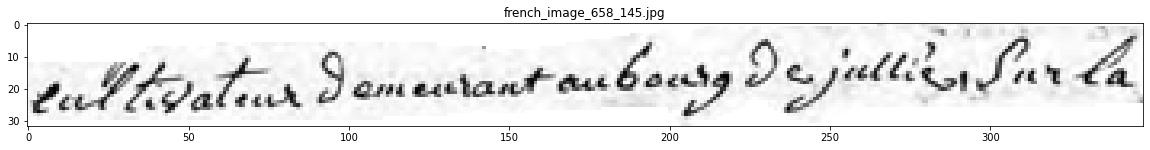

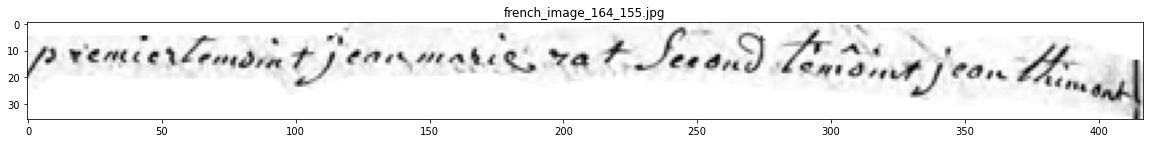

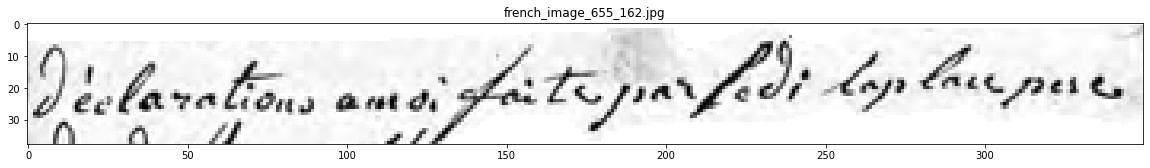

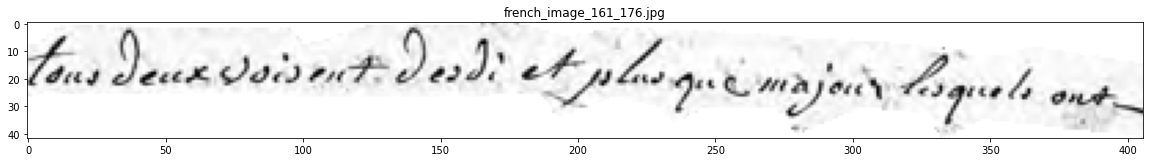

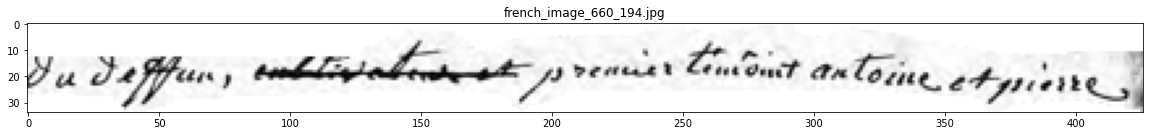

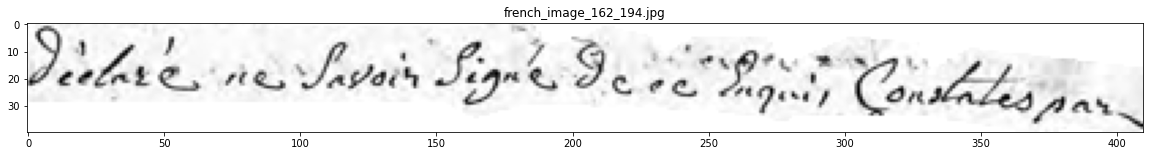

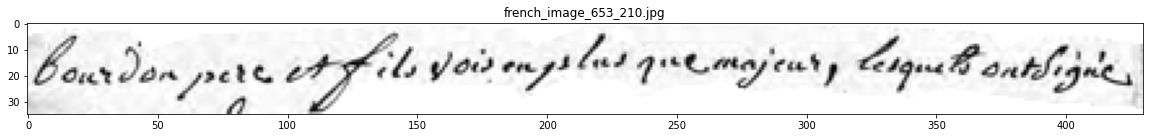

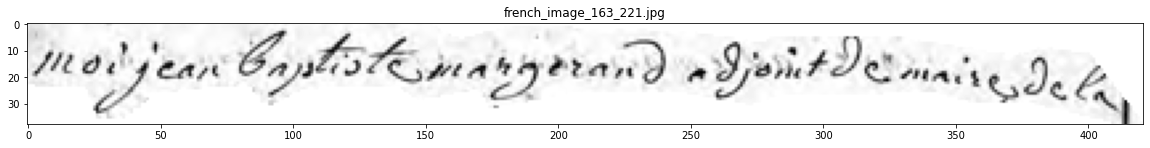

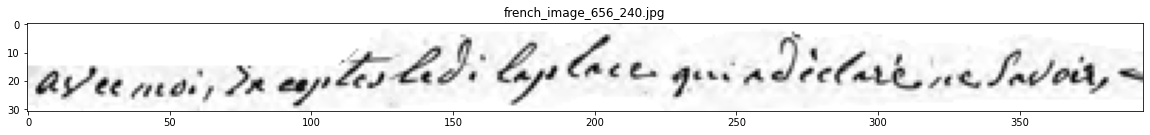

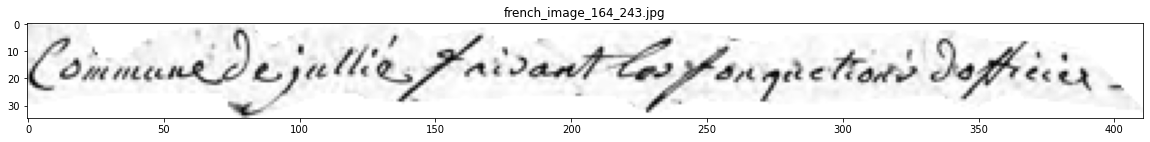

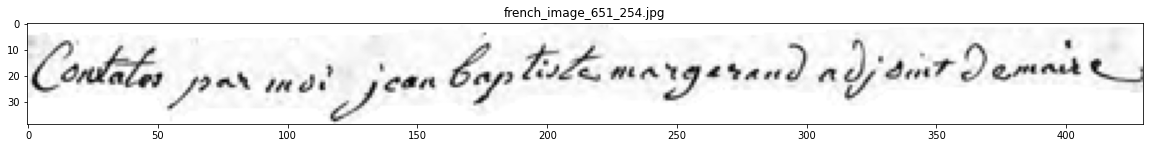

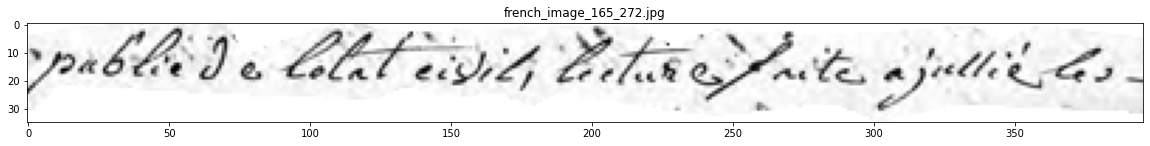

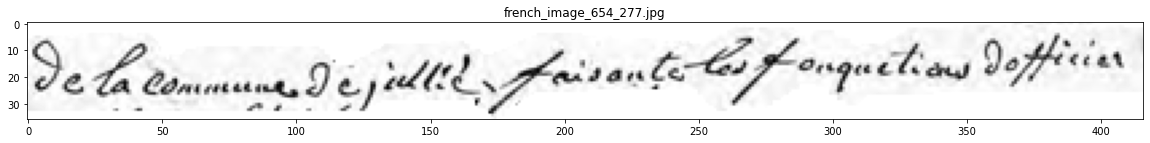

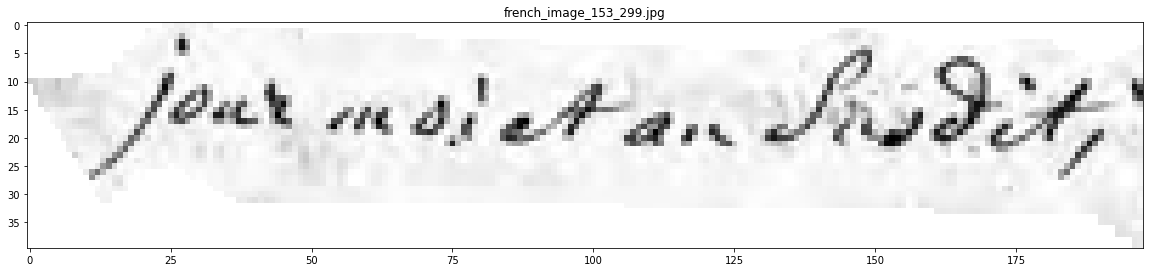

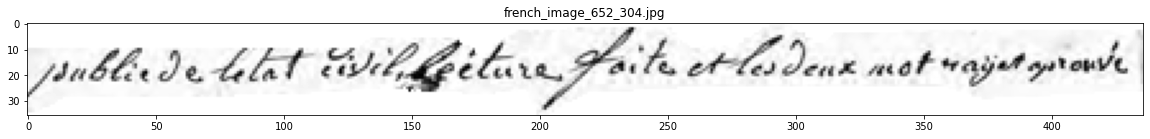

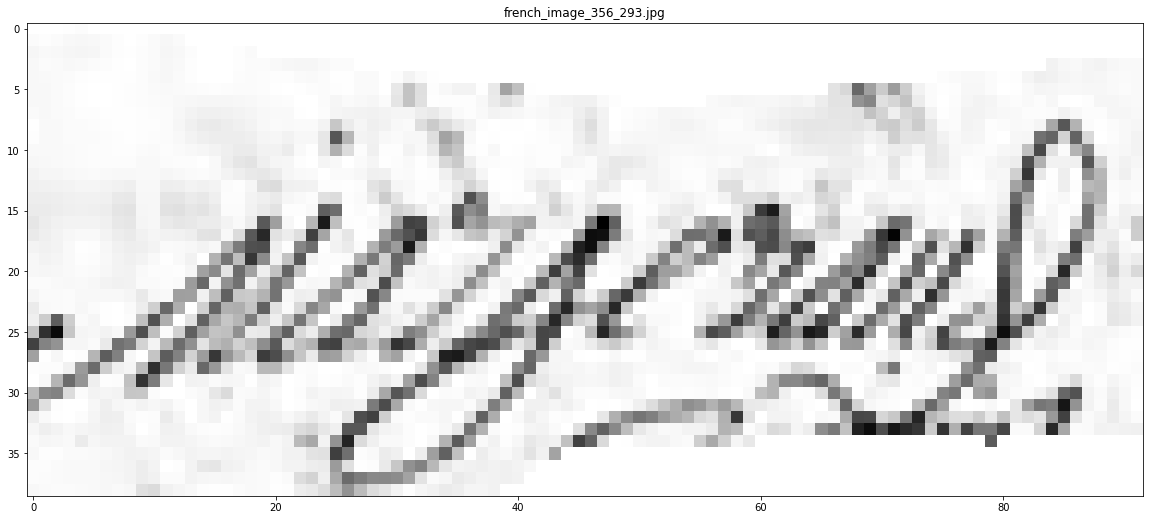

TypeError: ignored

In [82]:
print('Predicting Baselines...')
baseline_predictions = baseline_model(tf.expand_dims(image, axis=0))
print('Predicting Seams...')
seam_predictions = seam_model(tf.expand_dims(image, axis=0))

original_image = tf.squeeze(image).numpy()
baseline_pred_image = tf.squeeze(tf.argmax(baseline_predictions, axis=3)).numpy()
seam_pred_image = tf.squeeze(tf.argmax(seam_predictions, axis=3)).numpy()

print('Analyzing baseline and seam images for segmentation...')
image_name = 'french_image'
create_segments(original_image, baseline_pred_image, seam_pred_image, image_name, save_images=False, plot_images=True)

Download the image snippets (if they were written to disk) if desired.

In [0]:
from google.colab import files
!zip -r -q /content/image_snippets.zip /content/image_snippets/
files.download('image_snippets.zip')